In [1]:
# Title: ml pipeline v20 f37 p2
# Author: Henry M. Sanchez
# Date: 2024-03-03

In [ ]:
import multiprocessing
from joblib import Parallel, delayed
import os

import numpy as np
import pandas as pd
from math import ceil, sqrt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.model_selection import ParameterGrid
from scipy import stats
from scipy.stats import spearmanr
import statsmodels.api as smapi
from statsmodels.graphics.regressionplots import abline_plot
import shap

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

plt.style.use('default')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Nimbus Sans']

In [4]:
hulk_palette = ['#2AA46D', '#825CA6', '#F2B342', '#CCCCCC']
custom_palette = hulk_palette

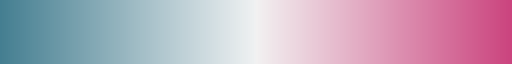

In [5]:
blue_pink_map = sns.diverging_palette(220, 350, s=70, as_cmap=True)
blue_pink_map

In [6]:
save_date = '20240303'
data_dir = '/home/sanchezh/Documents/PE_tagging_paper/data/'
model_dir = '/home/sanchezh/Documents/PE_tagging_paper/github/model/'
fig_dir = '/home/sanchezh/Documents/PE_tagging_paper/github/figures/'

In [7]:
model_info = 'model_v20_f37_p2'

In [8]:
fig_dir = fig_dir + 'figures_fig5_' + model_info + '/'

In [9]:
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print('Directory ' + fig_dir + ' was created.')
else:
    print('Directory ' + fig_dir + ' already exists.')

Directory /home/sanchezh/Documents/PE_tagging_paper/github/figures/figures_fig5_model_v20_f37_p2/ was created.


In [10]:
total_cores = multiprocessing.cpu_count()
n_cores = 48

print(total_cores, n_cores)

80 48


#################################################################################

read data

In [11]:
# lib data with gene features
# note here 'log2fc' refers to 'sort_2nd_log2fc_z' as noted in transform lines below

lib_df = pd.read_csv(data_dir + 'lib_with_bulk_data.csv')

lib_df['log2fc_mean_genes'] = lib_df.groupby('Gene')['sort_2nd_log2fc_z'].transform('mean')
lib_df['log2fc_max_genes'] = lib_df.groupby('Gene')['sort_2nd_log2fc_z'].transform('max')
lib_df['log2fc_std_genes'] = lib_df.groupby('Gene')['sort_2nd_log2fc_z'].transform('std')

lib_df['log2fc_mean_sublib_genes'] = lib_df.groupby(by=['Sublibrary_ID','Gene'])['sort_2nd_log2fc_z'].transform('mean')
lib_df['log2fc_max_sublib_genes'] = lib_df.groupby(by=['Sublibrary_ID','Gene'])['sort_2nd_log2fc_z'].transform('max')
lib_df['log2fc_std_sublib_genes'] = lib_df.groupby(by=['Sublibrary_ID','Gene'])['sort_2nd_log2fc_z'].transform('std')

# features
ml_compact_df = pd.read_csv(data_dir + 'ml_features_target_v20_f37_p2.csv')

# df for gene selection
pegRNA_target = 'pegRNA_ID'
target_og = 'sort_2nd_log2fc_z'
target = target_og + '_mean_centered'

In [12]:
# counts data for downstream analysis

target_counts = 'sort_2nd_spacerbar_counts_rpm_log2'

lib_df[target_counts + '_mean'] = lib_df.groupby('Sublibrary_ID')[target_counts].transform('mean')
lib_df[target_counts + '_std'] = lib_df.groupby('Sublibrary_ID')[target_counts].transform('std')
lib_df[target_counts + '_z'] = (lib_df[target_counts] - lib_df[target_counts + '_mean']) / lib_df[target_counts + '_std']

lib_df['counts_mean_genes'] = lib_df.groupby('Gene')[target_counts + '_z'].transform('mean')
lib_df['counts_max_genes'] = lib_df.groupby('Gene')[target_counts + '_z'].transform('max')
lib_df['counts_std_genes'] = lib_df.groupby('Gene')[target_counts + '_z'].transform('std')

lib_df['counts_mean_sublib_genes'] = lib_df.groupby(by=['Sublibrary_ID','Gene'])[target_counts + '_z'].transform('mean')
lib_df['counts_max_sublib_genes'] = lib_df.groupby(by=['Sublibrary_ID','Gene'])[target_counts + '_z'].transform('max')
lib_df['counts_std_sublib_genes'] = lib_df.groupby(by=['Sublibrary_ID','Gene'])[target_counts + '_z'].transform('std')

In [13]:
lib_df.shape

(16295, 89)

In [14]:
ml_compact_df.shape

(16295, 48)

In [15]:
ml_compact_df.columns

Index(['Sublibrary_ID', 'Tag_synonym_ID', 'Gene', 'Terminus', 'Strand',
       'pegRNA_ID', 'pegRNA_ID_without_sublibrary', 'pegRNA_ID_without_tag',
       'pegRNA_ID_without_sublibrary_and_without_tag', 'sort_2nd_log2fc_z',
       'On-Target Efficacy Score', 'RTTdha_length', 'Strand_num',
       'RTTdha_ins_RTTpha_A_content', 'ins_A_content', 'PBS_Tm',
       'RTTdha_U_content', 'Nick_index_centered', 'RTTpha_G+C_content',
       'RTTdha_ins_RTTpha_PBS_C_content', 'RTTdha_Tm', 'PBS_C_content',
       'RTTdha_G+C_content', 'RTTdha_ins_RTTpha_MFE', 'RTTpha_G_content',
       'RTTdha_ins_RTTpha_G_content', 'RTTdha_A_content', 'PBS_G_content',
       'RTTdha_G_content', 'RTTpha_U_content', 'PBS_G+C_content', 'RTTdha_MFE',
       'RTTdha_C_content', 'RTTdha_ins_RTTpha_C_content',
       'spacer_scaffold_RTTdha_ins_RTTpha_PBS_MFE',
       'RTTdha_ins_RTTpha_PBS_G_content', 'PBS_MFE', 'Nick_index_centered_abs',
       'RTTpha_C_content', 'spacer_scaffold_RTTdha_ins_RTTpha_PBS_Tm',
       'PB

In [16]:
genes_target_df = ml_compact_df.copy()

#################################################################################

read genes for model building

define features and target

In [17]:
genes_df = pd.read_csv(data_dir + 'KS_Test_one-side-less_FDR-0,1.csv').rename(columns={'sublib':'Sublibrary_ID', 
                                                                                       'gene':'Gene'})

In [18]:
genes_df.head()

,sgRNA,Gene,target,result,p-value,BC_sum,BC_mean,BC_std,Sublibrary_ID,truth,q-value
0,AATF_-26,AATF,True,0.491667,4.906226,-63.075811,-2.628159,1.190429,mNG2_48,True,4.358524
1,AATF_0,AATF,True,0.615399,7.679707,-32.078336,-1.394710,1.599784,mNG2_48,True,7.007066
2,AATF_12,AATF,True,0.350000,2.442160,-69.817763,-2.909073,1.693655,mNG2_48,True,2.016191
3,AATF_20,AATF,True,0.328261,2.091801,-64.989471,-2.825629,1.733781,mNG2_48,True,1.680073
4,ACTB_-27,ACTB,True,0.545833,2.759431,-25.066384,-2.506638,1.561789,mNG2_48,True,2.313718


In [19]:
genes_df['Sublibrary_ID_Gene'] = genes_df.apply(lambda row: row.Sublibrary_ID + '_' + row.Gene, axis=1)

In [20]:
genes_df['Sublibrary_ID_sgRNA'] = genes_df.apply(lambda row: row.Sublibrary_ID + '_' + row.sgRNA, axis=1)

In [21]:
genes_df['truth_bool'] = genes_df['truth'].apply(lambda x: 1 if x == 1 else 0)

In [22]:
genes_df['truth_bool_genes'] = genes_df.groupby('Sublibrary_ID_Gene')['truth_bool'].transform('max')

In [23]:
genes_df['truth_bool_spacers'] = genes_df.groupby('Sublibrary_ID_Gene')['truth_bool'].transform('sum')

In [24]:
genes_df[genes_df['Gene'] == 'ARFIP2'].head(100)

,sgRNA,Gene,target,result,p-value,BC_sum,BC_mean,BC_std,Sublibrary_ID,truth,q-value,Sublibrary_ID_Gene,Sublibrary_ID_sgRNA,truth_bool,truth_bool_genes,truth_bool_spacers
8,ARFIP2_-18,ARFIP2,True,0.070833,0.110578,-99.195845,-4.133160,1.588180,mNG2_48,False,0.054649,mNG2_48_ARFIP2,mNG2_48_ARFIP2_-18,0,0,0
9,ARFIP2_-11,ARFIP2,True,0.066667,0.098790,-101.121141,-4.213381,1.542963,mNG2_48,False,0.048992,mNG2_48_ARFIP2,mNG2_48_ARFIP2_-11,0,0,0
10,ARFIP2_15,ARFIP2,True,0.050000,0.059318,-105.325733,-4.388572,1.898630,mNG2_48,False,0.029355,mNG2_48_ARFIP2,mNG2_48_ARFIP2_15,0,0,0
11,ARFIP2_20,ARFIP2,True,0.033333,0.027895,-102.659679,-4.277487,1.569610,mNG2_48,False,0.015040,mNG2_48_ARFIP2,mNG2_48_ARFIP2_20,0,0,0
258,ARFIP2_-18,ARFIP2,True,0.150000,0.459356,-80.754268,-3.364761,1.693056,mNG2_60,False,0.272269,mNG2_60_ARFIP2,mNG2_60_ARFIP2_-18,0,1,1
259,ARFIP2_-11,ARFIP2,True,0.637500,8.575558,-37.213495,-1.550562,1.400309,mNG2_60,True,7.713860,mNG2_60_ARFIP2,mNG2_60_ARFIP2_-11,1,1,1
260,ARFIP2_15,ARFIP2,True,0.029167,0.022192,-98.799679,-4.116653,1.386779,mNG2_60,False,0.013048,mNG2_60_ARFIP2,mNG2_60_ARFIP2_15,0,1,1
261,ARFIP2_20,ARFIP2,True,0.108333,0.246085,-83.696255,-3.487344,1.747627,mNG2_60,False,0.137796,mNG2_60_ARFIP2,mNG2_60_ARFIP2_20,0,1,1
508,ARFIP2_-18,ARFIP2,True,0.395397,3.176441,-92.692832,-3.862201,1.734300,mNG2_78,True,2.833657,mNG2_78_ARFIP2,mNG2_78_ARFIP2_-18,1,1,3
509,ARFIP2_-11,ARFIP2,True,0.945781,24.718558,8.058035,0.335751,1.519242,mNG2_78,True,23.338347,mNG2_78_ARFIP2,mNG2_78_ARFIP2_-11,1,1,3


In [25]:
genes = lib_df['Gene'].drop_duplicates().to_list()

In [26]:
sublibs = ['mNG2_48', 'mNG2_60', 'mNG2_78']

genes_to_keep_and = []
genes_to_keep_or = []

for gene in genes:
    count = 0
    for sublib in sublibs:
        temp_df = genes_df[(genes_df['Sublibrary_ID'] == sublib) & (genes_df['Gene'] == gene)]
        if temp_df['truth_bool'].sum() >= 1:
            count += 1
        del temp_df
    if count >= 1:
        genes_to_keep_or.append(gene)
        if count == 3:
            genes_to_keep_and.append(gene)

In [27]:
len(genes_to_keep_and), len(genes_to_keep_or)

(37, 60)

In [28]:
# filter genes_target_df to include genes to keep
genes = genes_to_keep_and
filtered_genes_index = genes_target_df[genes_target_df['Gene'].isin(genes)].reset_index()['index'].to_list()

# obtain filtered feature and target dataframes
genes_target_filtered_df = genes_target_df.iloc[filtered_genes_index].reset_index(drop=True)
genes_target_filtered_df['y_test'] = np.nan
genes_target_filtered_df['y_pred'] = np.nan

X_df = ml_compact_df.iloc[:,10:-1]
y_df = ml_compact_df.iloc[:,-1]

X_final_df = X_df.iloc[filtered_genes_index]
y_final_df = y_df.iloc[filtered_genes_index]

X = X_final_df.to_numpy()
y = y_final_df.to_numpy()

In [29]:
genes_target_filtered_df.head()

,Sublibrary_ID,Tag_synonym_ID,Gene,Terminus,Strand,pegRNA_ID,pegRNA_ID_without_sublibrary,pegRNA_ID_without_tag,pegRNA_ID_without_sublibrary_and_without_tag,sort_2nd_log2fc_z,On-Target Efficacy Score,RTTdha_length,Strand_num,RTTdha_ins_RTTpha_A_content,ins_A_content,PBS_Tm,RTTdha_U_content,Nick_index_centered,RTTpha_G+C_content,RTTdha_ins_RTTpha_PBS_C_content,RTTdha_Tm,PBS_C_content,RTTdha_G+C_content,RTTdha_ins_RTTpha_MFE,RTTpha_G_content,RTTdha_ins_RTTpha_G_content,RTTdha_A_content,PBS_G_content,RTTdha_G_content,RTTpha_U_content,PBS_G+C_content,RTTdha_MFE,RTTdha_C_content,RTTdha_ins_RTTpha_C_content,spacer_scaffold_RTTdha_ins_RTTpha_PBS_MFE,RTTdha_ins_RTTpha_PBS_G_content,PBS_MFE,Nick_index_centered_abs,RTTpha_C_content,spacer_scaffold_RTTdha_ins_RTTpha_PBS_Tm,PBS_A_content,spacer_scaffold_RTTdha_ins_RTTpha_PBS_G_content,PBS_U_content,RTTdha_ins_RTTpha_G+C_content,First_extension_nucleotide_T,RTTdha_ins_RTTpha_PBS_U_content,PAM_disrupted,sort_2nd_log2fc_z_mean_centered,y_test,y_pred
0,mNG2_48,opti,AATF,N,+,mNG2_48_AATF_N_-26_opti_10_15,AATF_N_-26_opti_10_15,mNG2_48_AATF_N_-26_10_15,AATF_N_-26_10_15,-0.052707,0.2485,15,1,0.134831,0.166667,39.119692,0.066667,-26,0.653846,0.373737,61.264455,0.500000,0.933333,-23.200001,0.192308,0.258427,0.000000,0.300000,0.466667,0.192308,0.800000,-8.0,0.466667,0.359551,-73.800003,0.262626,-0.8,26,0.461538,82.193880,0.000000,0.276923,0.200000,0.617978,0,0.242424,1,-0.072666,NaN,NaN
1,mNG2_48,opti,AATF,N,+,mNG2_48_AATF_N_-26_opti_13_15,AATF_N_-26_opti_13_15,mNG2_48_AATF_N_-26_13_15,AATF_N_-26_13_15,-0.454326,0.2485,15,1,0.134831,0.166667,50.314724,0.066667,-26,0.653846,0.372549,61.264455,0.461538,0.933333,-23.200001,0.192308,0.258427,0.000000,0.307692,0.466667,0.192308,0.769231,-8.0,0.466667,0.359551,-81.000000,0.264706,-0.8,26,0.461538,82.329472,0.076923,0.277778,0.153846,0.617978,0,0.235294,1,-0.474285,NaN,NaN
2,mNG2_48,opti,AATF,N,+,mNG2_48_AATF_N_-26_opti_16_15,AATF_N_-26_opti_16_15,mNG2_48_AATF_N_-26_16_15,AATF_N_-26_16_15,-0.908850,0.2485,15,1,0.134831,0.166667,53.110732,0.066667,-26,0.653846,0.361905,61.264455,0.375000,0.933333,-23.200001,0.192308,0.258427,0.000000,0.250000,0.466667,0.192308,0.625000,-8.0,0.466667,0.359551,-84.599998,0.257143,-0.8,26,0.461538,82.150130,0.187500,0.273632,0.187500,0.617978,0,0.238095,1,-0.928809,NaN,NaN
3,mNG2_48,opti,AATF,N,+,mNG2_48_AATF_N_-26_opti_10_27,AATF_N_-26_opti_10_27,mNG2_48_AATF_N_-26_10_27,AATF_N_-26_10_27,0.705092,0.2485,27,1,0.138614,0.166667,39.119692,0.111111,-26,0.653846,0.369369,75.939901,0.500000,0.814815,-32.500000,0.192308,0.267327,0.074074,0.300000,0.407407,0.192308,0.800000,-11.9,0.407407,0.356436,-79.699997,0.270270,-0.8,26,0.461538,82.782765,0.000000,0.280193,0.200000,0.623762,1,0.234234,1,0.685134,NaN,NaN
4,mNG2_48,opti,AATF,N,+,mNG2_48_AATF_N_-26_opti_13_27,AATF_N_-26_opti_13_27,mNG2_48_AATF_N_-26_13_27,AATF_N_-26_13_27,0.404326,0.2485,27,1,0.138614,0.166667,50.314724,0.111111,-26,0.653846,0.368421,75.939901,0.461538,0.814815,-32.500000,0.192308,0.267327,0.074074,0.307692,0.407407,0.192308,0.769231,-11.9,0.407407,0.356436,-86.900002,0.271930,-0.8,26,0.461538,82.901709,0.076923,0.280952,0.153846,0.623762,1,0.228070,1,0.384367,NaN,NaN


In [30]:
genes_target_filtered_df.shape

(9873, 50)

In [31]:
X_final_df.shape

(9873, 37)

In [32]:
y_final_df.shape

(9873,)

#################################################################################

nested CV for model hyperparameter tuning and evaluation

In [33]:
# Training code was generated with the assistance of ChatGPT, developed by OpenAi.

In [34]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [3, 4, 5], 
    'learning_rate': [0.01, 0.05, 0.1], 
    'gamma': [0, 0.01, 0.1], 
    'alpha': [0, 0.01, 0.1], 
    'lambda': [0.01, 0.1, 1]
}


In [35]:
def evaluate_hyperparameters(params, X_train, y_train, train_groups, group_kfold, X, y, num_boost_round_default=100):
    inner_mse_scores = []
    params_to_try = params.copy()
    num_boost_round = params_to_try.pop('n_estimators', num_boost_round_default)

    for inner_train_idx, inner_val_idx in group_kfold.split(X_train, y_train, train_groups):
        X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
        y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]

        dtrain = xgb.DMatrix(X_inner_train, label=y_inner_train)
        dval = xgb.DMatrix(X_inner_val, label=y_inner_val)

        model = xgb.train(params_to_try, dtrain, num_boost_round=num_boost_round, evals=[(dtrain, 'train'), (dval, 'val')], verbose_eval=False)
        y_pred = model.predict(xgb.DMatrix(X_inner_val))
        mse = mean_squared_error(y_inner_val, y_pred)
        inner_mse_scores.append(mse)

    return np.mean(inner_mse_scores), params

In [36]:
###################################################################################################
# Nested CV
###################################################################################################

# Obtain integer-encoded gene groups and make mapping to original gene names
gene_samples = genes_target_filtered_df['Gene']
groups = pd.factorize(gene_samples)[0]
group_name_mapping = dict(zip(groups, gene_samples))

# Create list of all possible combinations of hyperparameters
all_params = list(ParameterGrid(param_grid))
best_params_frequency = {}

# Outer loop: Leave-One-Group-Out cross-validation
logo = LeaveOneGroupOut()

# Initialize lists to store outer fold mse scores and spearman correlations
outer_mse_scores = []
outer_spearman_corrs = []

for outer_fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    print(f"Starting outer fold {outer_fold+1}")    

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train_groups = groups[train_idx]

    best_params = None
    best_cv_score = float('inf')

    left_out_group = groups[test_idx][0]  # Assuming each test_idx corresponds to a single unique group

    # Inner loop: 6-fold stratified cross-validation within each group
    group_kfold = GroupKFold(n_splits=6)

    # Parallel computation
    n_jobs = n_cores  # -1
    verbose_level = 10
    print('total hyperparameter combinations:', len(all_params))
    results = Parallel(n_jobs=n_jobs, verbose=verbose_level)(delayed(evaluate_hyperparameters)(params, X_train, y_train, train_groups, group_kfold, X, y) 
                                      for params in all_params)

    for mean_mse, params in results:
        if mean_mse < best_cv_score:
            best_cv_score = mean_mse
            best_params = params

    # Keep track of best parameters frequency
    params_str = str(sorted(best_params.items()))  # Convert dictionary to string
    best_params_frequency[params_str] = best_params_frequency.get(params_str, 0) + 1

    # Train the final model on the full outer training set using the best parameters
    best_params_to_use = best_params.copy()
    best_num_boost_round = best_params_to_use.pop('n_estimators', 100)
    print('trying these best hyperparameters:', best_params_to_use) # print best_params_to_use
    print('best_num_boost_round:', best_num_boost_round) # print best_num_boost_round

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    final_model = xgb.train(best_params_to_use, dtrain, num_boost_round=best_num_boost_round, evals=[(dtrain, 'train')], 
                           verbose_eval=False) #verbose_eval=25

    # Make predictions on the test set of the outer loop
    y_pred = final_model.predict(dtest)

    # Update dataframe with test and predictions
    for idx, (test, pred) in zip(test_idx, zip(y_test, y_pred)):
        genes_target_filtered_df.at[idx, 'y_test'] = test
        genes_target_filtered_df.at[idx, 'y_pred'] = pred

    # Get left out group name
    left_out_group_name = group_name_mapping.get(left_out_group, str(left_out_group))  # Map to original group name if possible
    
    # Compute MSE on the test set of the outer loop
    outer_mse = mean_squared_error(y_test, y_pred)
    outer_mse_scores.append(outer_mse)
    print(f"Outer MSE for left-out group {left_out_group_name}: {outer_mse}")
    
    # Compute Spearman correlation for the left-out group
    spearman_corr = spearmanr(y_test, y_pred).correlation
    outer_spearman_corrs.append(spearman_corr)
    print(f"Spearman correlation for left-out group {left_out_group_name}: {spearman_corr}")
    print("")

# Average MSE score across outer folds
mean_outer_mse = np.mean(outer_mse_scores)
print(f'Average outer MSE: {mean_outer_mse}')

# Average Spearman correlation across outer folds
mean_spearman_corr = np.mean(outer_spearman_corrs)
print(f'Average Spearman correlation: {mean_spearman_corr}')

Starting outer fold 1
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    6.1s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    8.1s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:   10.4s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   12.6s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   14.6s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   17.2s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   19.5s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   22.1s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   25.1s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   27.9s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   31.0s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   34.0s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   37.4s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group AATF: 0.5728664677728649
Spearman correlation for left-out group AATF: 0.24993510280044762

Starting outer fold 2
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.9s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.6s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.9s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.6s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.5s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.5s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.5s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.5s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.9s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group ACTB: 0.505391579738813
Spearman correlation for left-out group ACTB: 0.4778404851717671

Starting outer fold 3
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.9s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.5s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.9s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.4s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.4s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.5s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.9s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 0.01, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group BAIAP2L1: 0.6271709093608053
Spearman correlation for left-out group BAIAP2L1: -0.048719875651054866

Starting outer fold 4
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.8s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.2s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.5s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group BCAP31: 0.803956462644495
Spearman correlation for left-out group BCAP31: 0.18306117303944194

Starting outer fold 5
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.7s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.4s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.1s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.4s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.6s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 0.1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 100
Outer MSE for left-out group CAPZB: 1.2363609916114244
Spearman correlation for left-out group CAPZB: 0.17351995501046374

Starting outer fold 6
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.7s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.9s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.5s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.4s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.2s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group CCT3: 1.0515823869148722
Spearman correlation for left-out group CCT3: 0.04605290438803349

Starting outer fold 7
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.3s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.5s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.7s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.1s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.2s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group COPE: 0.8288445284243168
Spearman correlation for left-out group COPE: 0.7073802315784373

Starting outer fold 8
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.8s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.5s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.4s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 0.1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group CORO1B: 0.7110544935141948
Spearman correlation for left-out group CORO1B: 0.2870855413265019

Starting outer fold 9
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.2s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.1s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.5s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.01, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group CSNK2A1: 0.7382218372515108
Spearman correlation for left-out group CSNK2A1: 0.6656821332376996

Starting outer fold 10
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.7s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.8s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.9s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.5s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.4s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.4s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.4s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.5s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.8s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0, 'lambda': 0.01, 'learning_rate': 0.1, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group EIF4A3: 0.7755752996260371
Spearman correlation for left-out group EIF4A3: 0.30334986534189207

Starting outer fold 11
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.3s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.8s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.3s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.6s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:   39.0s
[Parallel(n_jobs=48)]: Done 325 tasks      | elapsed:   42.7s
[Paralle

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 0.01, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group EMC4: 0.5709434901257072
Spearman correlation for left-out group EMC4: 0.5351538782837757

Starting outer fold 12
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.3s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.7s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.8s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.6s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.7s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.1s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.2s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.6s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group EMC7: 0.5154440361050509
Spearman correlation for left-out group EMC7: 0.15195877331325602

Starting outer fold 13
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.5s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.9s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.5s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.4s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0, 'lambda': 0.1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group HDAC1: 0.678915159873083
Spearman correlation for left-out group HDAC1: 0.5558202826957197

Starting outer fold 14
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.5s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.8s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.7s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.2s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.2s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.0s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.1s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.6s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group HMGA1: 0.8881895389235873
Spearman correlation for left-out group HMGA1: 0.4548543207340492

Starting outer fold 15
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.8s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.5s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.3s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0.01, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 100
Outer MSE for left-out group HSP90B1: 0.6173317295939637
Spearman correlation for left-out group HSP90B1: 0.07096980520548138

Starting outer fold 16
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.3s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.7s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.8s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.9s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.3s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.8s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group HSPBP1: 1.1757952604355089
Spearman correlation for left-out group HSPBP1: 0.4403770181293545

Starting outer fold 17
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.3s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.7s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.5s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group LAMTOR2: 1.329799761033813
Spearman correlation for left-out group LAMTOR2: 0.5696534165161535

Starting outer fold 18
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   13.0s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.6s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   18.0s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.5s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.5s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.4s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.4s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.7s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.9s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group LPCAT2: 0.5470493486111991
Spearman correlation for left-out group LPCAT2: 0.029279738980925608

Starting outer fold 19
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.3s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   13.0s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.5s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.9s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.3s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.4s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.9s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group NUP153: 0.547041624625207
Spearman correlation for left-out group NUP153: 0.0007681387947434254

Starting outer fold 20
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.8s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.2s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.2s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.6s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group PI4KB: 0.6457889318425197
Spearman correlation for left-out group PI4KB: 0.3150965917583799

Starting outer fold 21
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.5s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.8s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.3s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.5s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.4s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.3s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.4s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0, 'lambda': 0.01, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group PMVK: 1.093866849251432
Spearman correlation for left-out group PMVK: 0.47863290529676705

Starting outer fold 22
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.5s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.8s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.5s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.4s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 0.01, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group POLR2K: 0.7027969185496108
Spearman correlation for left-out group POLR2K: 0.3152756101083411

Starting outer fold 23
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.5s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.3s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.7s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.0s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.4s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.6s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group RAB3GAP2: 1.0783298770178351
Spearman correlation for left-out group RAB3GAP2: 0.46883987785246584

Starting outer fold 24
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.5s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.9s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group RBM10: 0.5731112238738961
Spearman correlation for left-out group RBM10: 0.28703453389552064

Starting outer fold 25
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.5s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.6s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.4s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.8s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 0.01, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group RIOK2: 0.9486967117989609
Spearman correlation for left-out group RIOK2: 0.6237546495230163

Starting outer fold 26
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.5s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.8s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.8s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.5s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.2s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.0s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.6s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 0.1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group SCAMP2: 1.2981212571370153
Spearman correlation for left-out group SCAMP2: -0.07447740497905009

Starting outer fold 27
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.7s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 0.01, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group SCAMP4: 0.7321196550373593
Spearman correlation for left-out group SCAMP4: 0.25405767065780926

Starting outer fold 28
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.8s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.7s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.2s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.5s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group SMARCB1: 0.5477968034877367
Spearman correlation for left-out group SMARCB1: 0.5370731851848219

Starting outer fold 29
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.5s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   13.0s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.6s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   18.0s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.6s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.5s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.5s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.4s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.6s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   36.0s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0.1, 'lambda': 0.1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group SPNS1: 0.7220793923479322
Spearman correlation for left-out group SPNS1: 0.2986473430160371

Starting outer fold 30
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.3s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.8s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.5s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.1s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.6s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group STT3B: 0.5797185906820564
Spearman correlation for left-out group STT3B: 0.5362354826280072

Starting outer fold 31
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.8s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.8s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.9s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.2s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group STX8: 0.4345233310095118
Spearman correlation for left-out group STX8: 0.4638898542191928

Starting outer fold 32
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.5s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.4s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.4s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.01, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group TERF2: 0.5255055934306587
Spearman correlation for left-out group TERF2: 0.25486003689784625

Starting outer fold 33
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.8s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.4s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.4s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.7s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group TUBG1: 0.7026231217315225
Spearman correlation for left-out group TUBG1: 0.5210949974476246

Starting outer fold 34
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.8s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.3s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.9s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.5s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.5s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.4s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.6s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.9s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.01, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group VCP: 0.8828691264426665
Spearman correlation for left-out group VCP: 0.4789109877044556

Starting outer fold 35
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.2s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.4s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.1s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.2s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.5s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:   38.9s
[Parallel(n_jobs=48)]: Done 325 tasks      | elapsed:   42.6s
[Paralle

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group YWHAH: 0.7940424330052024
Spearman correlation for left-out group YWHAH: 0.25270707639483436

Starting outer fold 36
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.5s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.4s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.8s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.3s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.6s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0.1, 'gamma': 0, 'lambda': 0.01, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group YWHAQ: 1.3983422761821658
Spearman correlation for left-out group YWHAQ: 0.04375938800327453

Starting outer fold 37
total hyperparameter combinations: 729


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=48)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done  32 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done  49 tasks      | elapsed:    8.7s
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.0s
[Parallel(n_jobs=48)]: Done  85 tasks      | elapsed:   12.7s
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:   15.5s
[Parallel(n_jobs=48)]: Done 125 tasks      | elapsed:   17.9s
[Parallel(n_jobs=48)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=48)]: Done 169 tasks      | elapsed:   23.4s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=48)]: Done 217 tasks      | elapsed:   29.3s
[Parallel(n_jobs=48)]: Done 242 tasks      | elapsed:   32.4s
[Parallel(n_jobs=48)]: Done 269 tasks      | elapsed:   35.8s
[Parallel(n_jobs=48)]: Done 296 tasks      | elapsed:  

trying these best hyperparameters: {'alpha': 0, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3}
best_num_boost_round: 50
Outer MSE for left-out group ZNF326: 1.363030589844474
Spearman correlation for left-out group ZNF326: 0.09805490750295859

Average outer MSE: 0.8039161510502436
Average Spearman correlation: 0.32452623194619984


#################################################################################

model analysis

In [37]:
def opti_anti_correlations_by_group(data, sublibs, group):
    
    sublib_corrs = {key: None for key in sublibs}
    groups = data[group].unique()
    x_var = target + '_anti'
    y_var = target + '_opti'

    for sublib in sublibs:
        group_corrs = []

        for g in groups:
            temp_df = data[(data['Sublibrary_ID'] == sublib) & (data[group] == g)]
            spearr = stats.spearmanr(temp_df[x_var], temp_df[y_var])[0]
            group_corrs.append(spearr)

        sublib_corrs[sublib] = group_corrs
        
    corrs_df = pd.DataFrame.from_dict(sublib_corrs)
    corrs_df[group] = groups
    corrs_long_df = corrs_df.melt(id_vars=[group], value_vars=sublibs, 
                                  var_name='Sublibrary_ID', value_name='opti_anti_spearman_corr')
    return corrs_long_df

In [38]:
opti_anti_df = ml_compact_df.copy()[['Sublibrary_ID', 'Gene', 'pegRNA_ID_without_tag', 'Tag_synonym_ID', target_og, target]]
opti_df = opti_anti_df[opti_anti_df['Tag_synonym_ID'] == 'opti'][['Sublibrary_ID', 'Gene', 'pegRNA_ID_without_tag', target_og, target]]
anti_df = opti_anti_df[opti_anti_df['Tag_synonym_ID'] == 'anti'][['pegRNA_ID_without_tag', target_og, target]]
opti_anti_merge_df = opti_df.merge(anti_df, on='pegRNA_ID_without_tag', how='inner', suffixes=('_opti', '_anti'))

In [39]:
opti_anti_merge_df['Sublibrary_ID_Gene'] = opti_anti_merge_df.apply(lambda row: row.Sublibrary_ID + '_' + row.Gene, axis=1)

In [40]:
opti_anti_merge_df.shape

(7977, 8)

In [41]:
opti_anti_merge_df = opti_anti_merge_df.merge(genes_df.drop_duplicates('Sublibrary_ID_Gene'), how='left', on=['Sublibrary_ID', 'Gene', 'Sublibrary_ID_Gene'])

In [42]:
opti_anti_merge_df.shape

(7977, 21)

In [43]:
# opti anti corrs by genes
opti_anti_corrs_genes_df = opti_anti_correlations_by_group(data=opti_anti_merge_df, sublibs=sublibs, group='Gene')

In [44]:
opti_anti_corrs_genes_df.shape

(180, 3)

In [45]:
genes_unique_df = genes_df.drop_duplicates('Sublibrary_ID_Gene')
genes_unique_df.shape

(210, 16)

In [46]:
opti_anti_corrs_genes_df = opti_anti_corrs_genes_df.merge(genes_unique_df, how='left', on=['Sublibrary_ID', 'Gene'])

In [47]:
opti_anti_corrs_genes_df.shape

(180, 17)

In [48]:
lib_genes_df = lib_df[['Sublibrary_ID', 'Gene', 'Terminus', 
                       'log2fc_mean_genes', 'log2fc_max_genes', 'log2fc_std_genes', 
                       'log2fc_mean_sublib_genes', 'log2fc_max_sublib_genes', 'log2fc_std_sublib_genes', 
                       'counts_mean_genes', 'counts_max_genes', 'counts_std_genes', 
                       'counts_mean_sublib_genes', 'counts_max_sublib_genes', 'counts_std_sublib_genes']]
lib_genes_df.shape

(16295, 15)

In [49]:
lib_genes_unique_df = lib_genes_df.drop_duplicates(subset=['Sublibrary_ID', 'Gene'])
lib_genes_unique_df.shape

(180, 15)

In [50]:
opti_anti_corrs_genes_df = opti_anti_corrs_genes_df.merge(lib_genes_unique_df, how='left', on=['Sublibrary_ID', 'Gene'])

In [51]:
opti_anti_corrs_genes_df.shape

(180, 30)

In [52]:
opti_anti_corrs_genes_df.head()

,Gene,Sublibrary_ID,opti_anti_spearman_corr,sgRNA,target,result,p-value,BC_sum,BC_mean,BC_std,truth,q-value,Sublibrary_ID_Gene,Sublibrary_ID_sgRNA,truth_bool,truth_bool_genes,truth_bool_spacers,Terminus,log2fc_mean_genes,log2fc_max_genes,log2fc_std_genes,log2fc_mean_sublib_genes,log2fc_max_sublib_genes,log2fc_std_sublib_genes,counts_mean_genes,counts_max_genes,counts_std_genes,counts_mean_sublib_genes,counts_max_sublib_genes,counts_std_sublib_genes
0,AATF,mNG2_48,0.293864,AATF_-26,True,0.491667,4.906226,-63.075811,-2.628159,1.190429,True,4.358524,mNG2_48_AATF,mNG2_48_AATF_-26,1,1,4,N,0.019959,2.573916,0.742449,0.104181,1.717002,0.662581,-0.016590,2.509890,0.905569,0.008625,1.968444,0.859330
1,ACTB,mNG2_48,0.722594,ACTB_-27,True,0.545833,2.759431,-25.066384,-2.506638,1.561789,True,2.313718,mNG2_48_ACTB,mNG2_48_ACTB_-27,1,1,4,N,0.625808,2.255426,0.799958,0.911637,2.255426,0.733680,0.504791,2.403304,0.949098,0.736305,2.152310,0.903037
2,ARFIP2,mNG2_48,-0.085106,ARFIP2_-18,True,0.070833,0.110578,-99.195845,-4.133160,1.588180,False,0.054649,mNG2_48_ARFIP2,mNG2_48_ARFIP2_-18,0,0,0,C,-0.261976,2.452117,0.871359,-0.617804,2.070544,0.652356,-0.134396,2.495120,0.866166,-0.448675,2.131690,0.701031
3,BAIAP2L1,mNG2_48,0.441986,BAIAP2L1_-17,True,0.366667,1.766424,-48.133738,-3.208916,1.362067,True,1.377439,mNG2_48_BAIAP2L1,mNG2_48_BAIAP2L1_-17,1,1,2,N,-0.216342,2.516402,0.699903,-0.263564,1.917255,0.614014,-0.269954,1.794075,0.712779,-0.306484,1.398778,0.637775
4,BAZ1A,mNG2_48,0.126489,BAZ1A_-16,True,0.285049,1.211009,-59.593200,-3.505482,1.156147,False,0.872190,mNG2_48_BAZ1A,mNG2_48_BAZ1A_-16,0,0,0,N,-0.474450,2.047069,0.606490,-0.487447,0.733945,0.542277,-0.612308,1.741774,0.630878,-0.637217,0.917230,0.630124


In [53]:
###################################################################################################
# Evaluate models (spearman correlation and precision at top k=10)
###################################################################################################

k = 10  # top k
min_pegRNA_count = 96  # max number of pegRNAs for a gene in a sublib

cols = ['Sublibrary_ID', 'Gene', 'spearman_corr', 'pegRNA_count', 'top_k_overlap_count']
eval_all_df = pd.DataFrame(columns=cols)

cols = ['Sublibrary_ID', 'spearman_corr', 'pegRNA_count', 'top_k_overlap_count', 'baseline_precision', 'top_k_precision']
eval_all_mean_selection_df = pd.DataFrame(columns=cols)

sublibs = ['mNG2_48', 'mNG2_60', 'mNG2_78']

for sublib in sublibs:
    sublib_corrs = []
    sublib_n = []
    sublib_top_k = []

    for gene in genes:
        temp_df = genes_target_filtered_df[(genes_target_filtered_df['Sublibrary_ID'] == sublib) & (genes_target_filtered_df['Gene'] == gene)]
        spearman_corr = spearmanr(temp_df['y_test'], temp_df['y_pred']).correlation
        sublib_corrs.append(spearman_corr)

        y_pred = temp_df['y_pred'].to_numpy()
        y_test = temp_df['y_test'].to_numpy()
        sublib_n.append(len(y_test))
        
        top_k_pred_indices = np.argsort(y_pred)[-k:]
        top_k_test_indices = np.argsort(y_test)[-k:]
        overlap_count = len(set(top_k_pred_indices) & set(top_k_test_indices))
        sublib_top_k.append(overlap_count)

    d = {'Sublibrary_ID' : [sublib]*len(genes), 'Gene' : genes, 'spearman_corr' : sublib_corrs, 
        'pegRNA_count' : sublib_n, 'top_k_overlap_count' : sublib_top_k}
    eval_df = pd.DataFrame(d)
    eval_all_df = pd.concat([eval_all_df, eval_df], axis=0)
    del d, eval_df

    print(sublib)
    temp_min_pegRNA_count = min(sublib_n)
    print('minimum number of pegRNAs for a given gene', temp_min_pegRNA_count)
    if temp_min_pegRNA_count < min_pegRNA_count:
        min_pegRNA_count = temp_min_pegRNA_count # min pegRNA count for a given gene across all sublibraries

eval_all_df['pegRNA_count'] = eval_all_df['pegRNA_count'].apply(lambda x: float(x))
eval_all_df['top_k_overlap_count'] = eval_all_df['top_k_overlap_count'].apply(lambda x: float(x))
eval_all_df['baseline_precision'] = eval_all_df['pegRNA_count'].apply(lambda x: k/x)
eval_all_df['top_k_precision'] = eval_all_df['top_k_overlap_count'].apply(lambda x: x/k)

eval_all_mean_df = eval_all_df.groupby(by=['Sublibrary_ID'])[['spearman_corr', 'pegRNA_count', 'top_k_overlap_count', 
                                                              'baseline_precision', 'top_k_precision']].mean().reset_index()
eval_all_mean_df['num_features'] = X_test.shape[1]
eval_all_mean_selection_df = pd.concat([eval_all_mean_selection_df, eval_all_mean_df], axis=0)
del eval_all_mean_df

eval_all_mean_selection_df['spearman_corr_mean'] = eval_all_mean_selection_df['spearman_corr'].mean()
eval_all_mean_selection_df['pegRNA_count_mean'] = eval_all_mean_selection_df['pegRNA_count'].mean()
eval_all_mean_selection_df['top_k_overlap_count_mean'] = eval_all_mean_selection_df['top_k_overlap_count'].mean()
eval_all_mean_selection_df['baseline_precision_mean'] = eval_all_mean_selection_df['baseline_precision'].mean()
eval_all_mean_selection_df['top_k_precision_mean'] = eval_all_mean_selection_df['top_k_precision'].mean()

mNG2_48
minimum number of pegRNAs for a given gene 55
mNG2_60
minimum number of pegRNAs for a given gene 55
mNG2_78
minimum number of pegRNAs for a given gene 61


In [54]:
eval_all_mean_selection_df

,Sublibrary_ID,spearman_corr,pegRNA_count,top_k_overlap_count,baseline_precision,top_k_precision,num_features,spearman_corr_mean,pegRNA_count_mean,top_k_overlap_count_mean,baseline_precision_mean,top_k_precision_mean
0,mNG2_48,0.321300,88.729730,2.405405,0.115003,0.240541,37.0,0.327759,88.945946,2.720721,0.114472,0.272072
1,mNG2_60,0.323633,88.729730,2.837838,0.114871,0.283784,37.0,0.327759,88.945946,2.720721,0.114472,0.272072
2,mNG2_78,0.338344,89.378378,2.918919,0.113541,0.291892,37.0,0.327759,88.945946,2.720721,0.114472,0.272072


In [55]:
eval_all_df.shape

(111, 7)

In [56]:
# merge eval_all_df with opti_anti_corrs_genes_df for downstream analysis
eval_all_df = eval_all_df.merge(opti_anti_corrs_genes_df, how='left', on=['Sublibrary_ID', 'Gene'])

In [57]:
eval_all_df.shape

(111, 35)

In [58]:
eval_all_df.head()

,Sublibrary_ID,Gene,spearman_corr,pegRNA_count,top_k_overlap_count,baseline_precision,top_k_precision,opti_anti_spearman_corr,sgRNA,target,result,p-value,BC_sum,BC_mean,BC_std,truth,q-value,Sublibrary_ID_Gene,Sublibrary_ID_sgRNA,truth_bool,truth_bool_genes,truth_bool_spacers,Terminus,log2fc_mean_genes,log2fc_max_genes,log2fc_std_genes,log2fc_mean_sublib_genes,log2fc_max_sublib_genes,log2fc_std_sublib_genes,counts_mean_genes,counts_max_genes,counts_std_genes,counts_mean_sublib_genes,counts_max_sublib_genes,counts_std_sublib_genes
0,mNG2_48,AATF,0.301459,94.0,0.0,0.106383,0.0,0.293864,AATF_-26,True,0.491667,4.906226,-63.075811,-2.628159,1.190429,True,4.358524,mNG2_48_AATF,mNG2_48_AATF_-26,1,1,4,N,0.019959,2.573916,0.742449,0.104181,1.717002,0.662581,-0.016590,2.509890,0.905569,0.008625,1.968444,0.859330
1,mNG2_48,ACTB,0.502898,72.0,4.0,0.138889,0.4,0.722594,ACTB_-27,True,0.545833,2.759431,-25.066384,-2.506638,1.561789,True,2.313718,mNG2_48_ACTB,mNG2_48_ACTB_-27,1,1,4,N,0.625808,2.255426,0.799958,0.911637,2.255426,0.733680,0.504791,2.403304,0.949098,0.736305,2.152310,0.903037
2,mNG2_48,BAIAP2L1,0.032931,87.0,2.0,0.114943,0.2,0.441986,BAIAP2L1_-17,True,0.366667,1.766424,-48.133738,-3.208916,1.362067,True,1.377439,mNG2_48_BAIAP2L1,mNG2_48_BAIAP2L1_-17,1,1,2,N,-0.216342,2.516402,0.699903,-0.263564,1.917255,0.614014,-0.269954,1.794075,0.712779,-0.306484,1.398778,0.637775
3,mNG2_48,BCAP31,0.169375,96.0,1.0,0.104167,0.1,0.210921,BCAP31_-20,True,0.641667,8.700795,-42.249570,-1.760399,1.357045,True,7.983341,mNG2_48_BCAP31,mNG2_48_BCAP31_-20,1,1,4,C,0.394961,2.152722,0.880355,0.490227,1.814647,0.794642,0.452563,2.116710,0.844340,0.525939,2.090609,0.782677
4,mNG2_48,CAPZB,0.391216,85.0,4.0,0.117647,0.4,0.602227,CAPZB_-30,True,1.000000,33.857648,85.573483,3.565562,0.904898,True,31.477437,mNG2_48_CAPZB,mNG2_48_CAPZB_-30,1,1,3,N,0.319845,3.018238,1.128603,0.644111,3.018238,1.300335,-0.118327,2.699804,1.118269,0.135709,2.699804,1.347911


In [59]:
###################################################################################################
# Evaluate models (precision at top k for k up to minimum pegRNA count)
###################################################################################################

top_k = list(range(1, min_pegRNA_count+1))

cols = ['top_k', 'Sublibrary_ID', 'Gene', 'pegRNA_count', 'top_k_overlap_count']
top_k_all_concat_df = pd.DataFrame(columns=cols)

cols = ['top_k', 'Sublibrary_ID', 'pegRNA_count', 'top_k_overlap_count', 'baseline_precision', 'top_k_precision']
top_k_all_mean_selection_df = pd.DataFrame(columns=cols)

sublibs = ['mNG2_48', 'mNG2_60', 'mNG2_78']
    
for k in top_k:
    
    if k % 5 == 0:
        print(k)
    
    cols = ['top_k', 'Sublibrary_ID', 'Gene', 'pegRNA_count', 'top_k_overlap_count']
    top_k_all_df = pd.DataFrame(columns=cols)
    
    for sublib in sublibs:
        sublib_n = []
        sublib_top_k = []
        
        for gene in genes:
            temp_df = genes_target_filtered_df[(genes_target_filtered_df['Sublibrary_ID'] == sublib) & (genes_target_filtered_df['Gene'] == gene)]
            
            y_pred = temp_df['y_pred'].to_numpy()
            y_test = temp_df['y_test'].to_numpy()
            sublib_n.append(len(y_test))

            top_k_pred_indices = np.argsort(y_pred)[-k:]
            top_k_test_indices = np.argsort(y_test)[-k:]
            overlap_count = len(set(top_k_pred_indices) & set(top_k_test_indices))
            sublib_top_k.append(overlap_count)
    
        d = {'top_k' : [k]*len(genes), 'Sublibrary_ID' : [sublib]*len(genes), 'Gene' : genes, 
             'pegRNA_count' : sublib_n, 'top_k_overlap_count' : sublib_top_k}
        eval_df = pd.DataFrame(d)
        top_k_all_df = pd.concat([top_k_all_df, eval_df], axis=0)
        top_k_all_concat_df = pd.concat([top_k_all_concat_df, eval_df], axis=0)
        del d, eval_df
    
    top_k_all_df['pegRNA_count'] = top_k_all_df['pegRNA_count'].apply(lambda x: float(x))
    top_k_all_df['top_k_overlap_count'] = top_k_all_df['top_k_overlap_count'].apply(lambda x: float(x))
    top_k_all_df['baseline_precision'] = top_k_all_df['pegRNA_count'].apply(lambda x: k/x)
    top_k_all_df['top_k_precision'] = top_k_all_df['top_k_overlap_count'].apply(lambda x: x/k)

    top_k_all_mean_df = top_k_all_df.groupby(by=['top_k', 'Sublibrary_ID'])[['pegRNA_count', 'top_k_overlap_count', 
                                                                  'baseline_precision', 'top_k_precision']].mean().reset_index()
    top_k_all_mean_df['num_features'] = X_test.shape[1]
    top_k_all_mean_selection_df = pd.concat([top_k_all_mean_selection_df, top_k_all_mean_df], axis=0)
    
    del top_k_all_mean_df

top_k_all_concat_df = top_k_all_concat_df.reset_index(drop=True)
top_k_all_concat_df['pegRNA_count'] = top_k_all_concat_df['pegRNA_count'].apply(lambda x: float(x))
top_k_all_concat_df['top_k_overlap_count'] = top_k_all_concat_df['top_k_overlap_count'].apply(lambda x: float(x))
top_k_all_concat_df['baseline_precision'] = top_k_all_concat_df.apply(lambda row: row.top_k/row.pegRNA_count, axis=1)
top_k_all_concat_df['top_k_precision'] = top_k_all_concat_df.apply(lambda row: row.top_k_overlap_count/row.top_k, axis=1)

top_k_all_mean_selection_df = top_k_all_mean_selection_df.reset_index(drop=True)
top_k_all_mean_selection_df['pegRNA_count_mean'] = top_k_all_mean_selection_df.groupby('top_k')['pegRNA_count'].transform('mean')
top_k_all_mean_selection_df['top_k_overlap_count_mean'] = top_k_all_mean_selection_df.groupby('top_k')['top_k_overlap_count'].transform('mean')
top_k_all_mean_selection_df['baseline_precision_mean'] = top_k_all_mean_selection_df.groupby('top_k')['baseline_precision'].transform('mean')
top_k_all_mean_selection_df['top_k_precision_mean'] = top_k_all_mean_selection_df.groupby('top_k')['top_k_precision'].transform('mean')

5
10
15
20
25
30
35
40
45
50
55


In [60]:
top_k_all_concat_df['Sublibrary_ID_Gene'] = top_k_all_concat_df.apply(lambda row: row.Sublibrary_ID + '_' + row.Gene, axis=1)

In [61]:
top_k_all_mean_selection_df.shape

(165, 11)

In [62]:
top_k_all_mean_selection_df.head()

,top_k,Sublibrary_ID,pegRNA_count,top_k_overlap_count,baseline_precision,top_k_precision,num_features,pegRNA_count_mean,top_k_overlap_count_mean,baseline_precision_mean,top_k_precision_mean
0,1,mNG2_48,88.729730,0.027027,0.011500,0.027027,37.0,88.945946,0.036036,0.011447,0.036036
1,1,mNG2_60,88.729730,0.081081,0.011487,0.081081,37.0,88.945946,0.036036,0.011447,0.036036
2,1,mNG2_78,89.378378,0.000000,0.011354,0.000000,37.0,88.945946,0.036036,0.011447,0.036036
3,2,mNG2_48,88.729730,0.108108,0.023001,0.054054,37.0,88.945946,0.117117,0.022894,0.058559
4,2,mNG2_60,88.729730,0.135135,0.022974,0.067568,37.0,88.945946,0.117117,0.022894,0.058559


In [63]:
# 3*37*55 = 6105
top_k_all_concat_df.shape

(6105, 8)

In [64]:
top_k_all_concat_df[top_k_all_concat_df['top_k'] == 10]

,top_k,Sublibrary_ID,Gene,pegRNA_count,top_k_overlap_count,baseline_precision,top_k_precision,Sublibrary_ID_Gene
999,10,mNG2_48,AATF,94.0,0.0,0.106383,0.0,mNG2_48_AATF
1000,10,mNG2_48,ACTB,72.0,4.0,0.138889,0.4,mNG2_48_ACTB
1001,10,mNG2_48,BAIAP2L1,87.0,2.0,0.114943,0.2,mNG2_48_BAIAP2L1
1002,10,mNG2_48,BCAP31,96.0,1.0,0.104167,0.1,mNG2_48_BCAP31
1003,10,mNG2_48,CAPZB,85.0,4.0,0.117647,0.4,mNG2_48_CAPZB
1004,10,mNG2_48,CCT3,96.0,2.0,0.104167,0.2,mNG2_48_CCT3
1005,10,mNG2_48,COPE,96.0,0.0,0.104167,0.0,mNG2_48_COPE
1006,10,mNG2_48,CORO1B,92.0,2.0,0.108696,0.2,mNG2_48_CORO1B
1007,10,mNG2_48,CSNK2A1,96.0,7.0,0.104167,0.7,mNG2_48_CSNK2A1
1008,10,mNG2_48,EIF4A3,74.0,7.0,0.135135,0.7,mNG2_48_EIF4A3


#################################################################################

spearman correlation plots

In [65]:
model_corrs_genes_df = pd.DataFrame({'gene': genes, 
                                     'spearman_corr': outer_spearman_corrs})

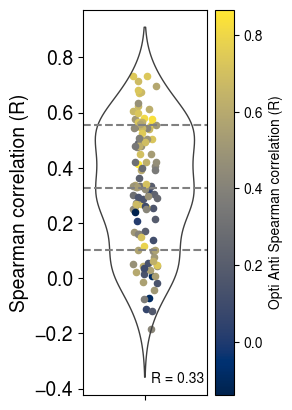

In [66]:
# sublib genes spearman corrs colored by opti anti spearman corr
# note, random jitter by stripplot may introduce different shifts of dots in horizontal direction between runs
# in future iteration use a fixed seed to keep display of dots consistent between runs

# data variables
data = eval_all_df.copy()
x_var = None
y_var = 'spearman_corr'
hue_var = 'opti_anti_spearman_corr'

# plot parameters
fig_size = (2,5)
fontsize = 14
x_label = None
y_label = 'Spearman correlation (R)'
#legend_labels=['FDR < 0.1', 'FDR > 0.1']
#current_palette='RdBu'
#colors = [sns.color_palette(current_palette)[1], sns.color_palette(current_palette)[-2]]
#current_cmap = blue_pink_map
current_cmap = 'cividis'

plt.figure(figsize=fig_size)

"""
g = sns.stripplot(data=data, y=y_var, hue=hue_var, 
                  palette=current_palette, alpha=0.5, dodge=True)
"""

g = sns.stripplot(data=data, y=y_var, alpha=0, dodge=True)


# Generate a colormap
norm = plt.Normalize(data[hue_var].min(), data[hue_var].max())
sm = plt.cm.ScalarMappable(cmap=current_cmap, norm=norm)
sm.set_array([])

# Color the points based on another variable
colors = sm.to_rgba(data[hue_var])
for x_i, y_i, color in zip(g.collections[0].get_offsets()[:,0], g.collections[0].get_offsets()[:,1], colors):
    g.scatter(x_i, y_i, color=color, s=20, alpha=1)

# Create a colorbar
cbar = plt.colorbar(sm, ax=g)
cbar.set_label('Opti Anti Spearman correlation (R)')

g = sns.violinplot(data=data, y=y_var, inner=None, linewidth=1)
art = g.collections[-1]
art.set_facecolor('none')

"""
# calculate means
means = data.groupby(hue_var)[y_var].mean()

# add horizontal lines for means
for (hue, mean), color in zip(means.items(), colors):
    plt.axhline(y=mean, color=color, linestyle='--', alpha=1)
"""

mean = data[y_var].mean()
std = data[y_var].std()
plt.axhline(y=mean, color='grey', linestyle='--', alpha=1)
plt.axhline(y=mean-std, color='grey', linestyle='--', alpha=1)
plt.axhline(y=mean+std, color='grey', linestyle='--', alpha=1)

plt.text(0.05,-0.38,'R = ' + str(round(mean,2)))

# x
plt.xticks(fontsize=fontsize)
plt.xlabel(x_label, fontsize=fontsize)

# y
plt.yticks(fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)

# legend
"""
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], legend_labels, handletextpad=0.1, fontsize=12, frameon=False, 
           loc='center', bbox_to_anchor=(0.45, 1.08))
"""

########## save fig ##########
fig_name = 'fig5_' + save_date + '_' + model_info + '_spearman_corr_sublib_genes_with_opti_anti_spearman_corr_colorbar_stripplot'
plt.savefig(fig_dir + fig_name + '.svg', dpi=1200, bbox_inches='tight')

# show plot
plt.show()

(37, 2)


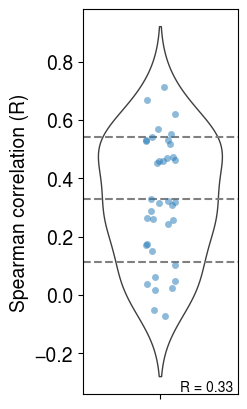

In [67]:
# sublib genes spearman corrs (averaged by sublib)
# note, random jitter by stripplot may introduce different shifts of dots in horizontal direction between runs
# in future iteration use a fixed seed to keep display of dots consistent between runs

# data variables
data = eval_all_df.copy().groupby('Gene')['spearman_corr'].mean().reset_index()
print(data.shape)
x_var = None
y_var = 'spearman_corr'
#hue_var = 'opti_anti_spearman_corr'

# plot parameters
fig_size = (2,5)
fontsize = 14
x_label = None
y_label = 'Spearman correlation (R)'
#legend_labels=['FDR < 0.1', 'FDR > 0.1']
#current_palette='RdBu'
#colors = [sns.color_palette(current_palette)[1], sns.color_palette(current_palette)[-2]]
#current_cmap = blue_pink_map
#current_cmap = 'cividis'

plt.figure(figsize=fig_size)

"""
g = sns.stripplot(data=data, y=y_var, hue=hue_var, 
                  palette=current_palette, alpha=0.5, dodge=True)
"""

g = sns.stripplot(data=data, y=y_var, alpha=0.5, dodge=True)


"""
# Generate a colormap
norm = plt.Normalize(data[hue_var].min(), data[hue_var].max())
sm = plt.cm.ScalarMappable(cmap=current_cmap, norm=norm)
sm.set_array([])

# Color the points based on another variable
colors = sm.to_rgba(data[hue_var])
for x_i, y_i, color in zip(g.collections[0].get_offsets()[:,0], g.collections[0].get_offsets()[:,1], colors):
    g.scatter(x_i, y_i, color=color, s=20)

# Create a colorbar
cbar = plt.colorbar(sm, ax=g)
cbar.set_label('Opti Anti Spearman correlation (R)')
"""

g = sns.violinplot(data=data, y=y_var, inner=None, linewidth=1)
art = g.collections[-1]
art.set_facecolor('none')

"""
# calculate means
means = data.groupby(hue_var)[y_var].mean()

# add horizontal lines for means
for (hue, mean), color in zip(means.items(), colors):
    plt.axhline(y=mean, color=color, linestyle='--', alpha=1)
"""

mean = data[y_var].mean()
std = data[y_var].std()
plt.axhline(y=mean, color='grey', linestyle='--', alpha=1)
plt.axhline(y=mean-std, color='grey', linestyle='--', alpha=1)
plt.axhline(y=mean+std, color='grey', linestyle='--', alpha=1)

plt.text(0.125,-0.33,'R = ' + str(round(mean,2)))

# x
plt.xticks(fontsize=fontsize)
plt.xlabel(x_label, fontsize=fontsize)

# y
plt.yticks(fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)

# legend
"""
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], legend_labels, handletextpad=0.1, fontsize=12, frameon=False, 
           loc='center', bbox_to_anchor=(0.45, 1.08))
"""

########## save fig ##########
fig_name = 'fig5_' + save_date + '_' + model_info + '_spearman_corr_sublib_genes_averaged_by_sublib_stripplot'
plt.savefig(fig_dir + fig_name + '.svg', dpi=1200, bbox_inches='tight')

# show plot
plt.show()

Spearman R:  0.4572481572481572  pvalue:  4.5362415529926425e-07
Parameters:  const                      0.120129
opti_anti_spearman_corr    0.438576
dtype: float64
R2:  0.20107237700120906


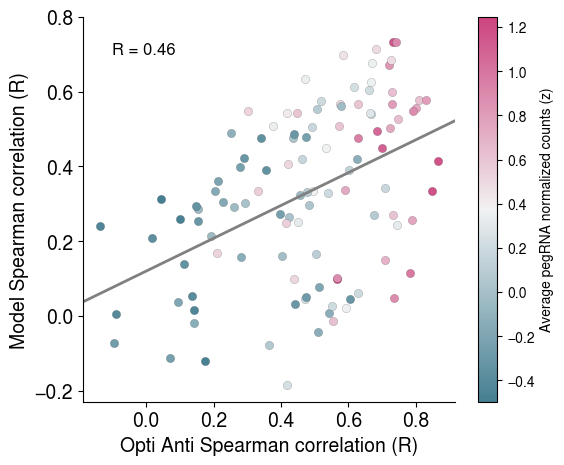

In [68]:
# model spearman corr vs opti anti spearman corr for sublib genes colored by sort_2nd_spacerbar_counts_rpm_log2_z_mean (scatterplot)

# data variables
data = eval_all_df.copy()
x_var = 'opti_anti_spearman_corr'
y_var = 'spearman_corr'
hue_var = 'counts_mean_sublib_genes'

# plot parameters
current_cmap = blue_pink_map
fontsize = 14
x_label = 'Opti Anti Spearman correlation (R)'
y_label = 'Model Spearman correlation (R)'
hue_label = 'Average pegRNA normalized counts (z)'
ymax_manual = 0.8

# plot scatterplot
plt.figure(figsize=(6,5))

g = sns.scatterplot(data=data, x=x_var, y=y_var, alpha=0, edgecolor=None)

# Generate a colormap
norm = plt.Normalize(data[hue_var].min(), data[hue_var].max())
sm = plt.cm.ScalarMappable(cmap=current_cmap, norm=norm)
sm.set_array([])

# Color the points based on another variable
colors = sm.to_rgba(data[hue_var])
for x_i, y_i, color in zip(g.collections[0].get_offsets()[:,0], g.collections[0].get_offsets()[:,1], colors):
    g.scatter(x_i, y_i, color=color, alpha=1, edgecolor='k', linewidth=0.1)

# Create a colorbar
cbar = plt.colorbar(sm, ax=g)
cbar.set_label(hue_label)

# correlation
x_mod = data[x_var]
y_mod = data[y_var]
spearman_r, spearman_pval = stats.spearmanr(x_mod, y_mod)
plt.text(-0.1,0.7,'R = ' + str(round(spearman_r,2)), fontsize=12)
print('Spearman R: ', spearman_r, ' pvalue: ', spearman_pval)

# regress
model = smapi.OLS(y_mod, smapi.add_constant(x_mod))
model_results=model.fit()
abline_plot(model_results=model.fit(), color='grey', linewidth=2, linestyle='-', ax=g)
print('Parameters: ', model_results.params)
print('R2: ', model_results.rsquared)

# spines
for spine in ['top', 'right']:
    g.spines[spine].set_visible(False)

# x
#xmin, xmax = g.get_xlim()
#g.set_xlim(xmin, xmax_manual)
plt.xticks(fontsize=fontsize)
plt.xlabel(x_label, fontsize=fontsize)

# y
ymin, ymax = g.get_ylim()
g.set_ylim(ymin, ymax_manual)
plt.yticks(fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)

# legend
#handles, _ = plt.gca().get_legend_handles_labels()
#plt.legend(handles, legend_labels, fontsize=10, frameon=False, loc='upper left')
#plt.legend(fontsize=10, frameon=False, loc='upper left')

# title
#plt.title('')

########## save fig ##########
fig_name = 'fig5_' + save_date + '_' + model_info + '_model_spearman_corr_opti_anti_spearman_corr_sublib_genes_colored_by_sort_2nd_spacerbar_counts_rpm_log2_z_mean_scatterplot'
plt.savefig(fig_dir + fig_name + '.svg', dpi=1200, bbox_inches='tight')

# show plot
plt.show()

Spearman R:  0.4129694629694629  pvalue:  6.656355243965534e-06
Parameters:  const                       0.283980
counts_mean_sublib_genes    0.191081
dtype: float64
R2:  0.14580302719743232


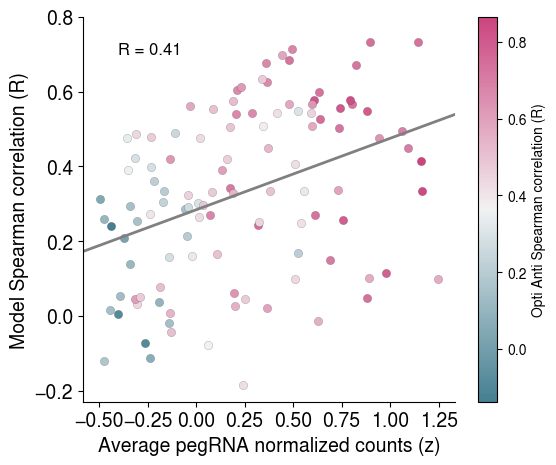

In [69]:
# model spearman corr vs sort_2nd_spacerbar_counts_rpm_log2_z_mean for sublib genes colored by opti anti spearman corr (scatterplot)

# data variables
data = eval_all_df.copy()
x_var = 'counts_mean_sublib_genes'
y_var = 'spearman_corr'
hue_var = 'opti_anti_spearman_corr'

# plot parameters
current_cmap = blue_pink_map
fontsize = 14
x_label = 'Average pegRNA normalized counts (z)'
y_label = 'Model Spearman correlation (R)'
hue_label = 'Opti Anti Spearman correlation (R)'
ymax_manual = 0.8

# plot scatterplot
plt.figure(figsize=(6,5))

g = sns.scatterplot(data=data, x=x_var, y=y_var, alpha=0, edgecolor=None)

# Generate a colormap
norm = plt.Normalize(data[hue_var].min(), data[hue_var].max())
sm = plt.cm.ScalarMappable(cmap=current_cmap, norm=norm)
sm.set_array([])

# Color the points based on another variable
colors = sm.to_rgba(data[hue_var])
for x_i, y_i, color in zip(g.collections[0].get_offsets()[:,0], g.collections[0].get_offsets()[:,1], colors):
    g.scatter(x_i, y_i, color=color, alpha=1, edgecolor='k', linewidth=0.1)

# Create a colorbar
cbar = plt.colorbar(sm, ax=g)
cbar.set_label(hue_label)

# correlation
x_mod = data[x_var]
y_mod = data[y_var]
spearman_r, spearman_pval = stats.spearmanr(x_mod, y_mod)
plt.text(-0.4,0.7,'R = ' + str(round(spearman_r,2)), fontsize=12)
print('Spearman R: ', spearman_r, ' pvalue: ', spearman_pval)

# regress
model = smapi.OLS(y_mod, smapi.add_constant(x_mod))
model_results=model.fit()
abline_plot(model_results=model.fit(), color='grey', linewidth=2, linestyle='-', ax=g)
print('Parameters: ', model_results.params)
print('R2: ', model_results.rsquared)

# spines
for spine in ['top', 'right']:
    g.spines[spine].set_visible(False)

# x
#xmin, xmax = g.get_xlim()
#g.set_xlim(xmin, xmax_manual)
plt.xticks(fontsize=fontsize)
plt.xlabel(x_label, fontsize=fontsize)

# y
ymin, ymax = g.get_ylim()
g.set_ylim(ymin, ymax_manual)
plt.yticks(fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)

# legend
#handles, _ = plt.gca().get_legend_handles_labels()
#plt.legend(handles, legend_labels, fontsize=10, frameon=False, loc='upper left')
#plt.legend(fontsize=10, frameon=False, loc='upper left')

# title
#plt.title('')

########## save fig ##########
fig_name = 'fig5_' + save_date + '_' + model_info + '_model_spearman_corr_sort_2nd_spacerbar_counts_rpm_log2_z_mean_sublib_genes_colored_by_opti_anti_spearman_corr_scatterplot'
plt.savefig(fig_dir + fig_name + '.svg', dpi=1200, bbox_inches='tight')

# show plot
plt.show()

In [70]:
###################################################################################################
# Model predictions for example genes
###################################################################################################

In [71]:
def four_example_genes_model_predictions_by_sublib_scatterplot(input_df, four_genes, four_genes_descriptor, legend_flag=0):
    sublib_names = ['mNG2_48', 'mNG2_60', 'mNG2_78']
    gene_examples = four_genes

    # data variables
    data = input_df.copy()
    x_var = 'y_test'
    y_var = 'y_pred'
    hue_var = 'Sublibrary_ID'

    # plot parameters
    fontsize = 14
    x_label = 'Observed'
    y_label = 'Predicted'
    #legend_labels = ['48 bp library', '60 bp library', '78 bp library']
    #ymax_manual = 0.8

    n_total = len(gene_examples)
    n_cols = int(ceil(sqrt(n_total)))
    n_rows = int(ceil(n_total / n_cols))

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = axes.flatten()

    for g, gene in enumerate(gene_examples):
        print(g, gene)

        ax = axes[g]
        temp_df = data[data['Gene'] == gene]

        sns.scatterplot(data=temp_df, x=x_var, y=y_var, hue=hue_var, 
                        ax=ax, alpha=0.7, s=15, edgecolor=None, palette=custom_palette)

        # correlation and regression
        count = 0
        spearman_r_list = []
        for i in sublib_names:

            x_mod = temp_df[temp_df['Sublibrary_ID'] == i][x_var]
            y_mod = temp_df[temp_df['Sublibrary_ID'] == i][y_var]

            # correlation
            spearman_r, spearman_pval = stats.spearmanr(x_mod, y_mod)
            spearman_r_list.append(spearman_r)
            #legend_labels[count] = legend_labels[count] + ', R = ' + str(round(spearman_r,2))
            #print(i, ' ', legend_labels[count])
            print(i)
            print('Spearman R: ', spearman_r, ' pvalue: ', spearman_pval)

            # regress
            model = smapi.OLS(y_mod, smapi.add_constant(x_mod))
            model_results=model.fit()
            abline_plot(model_results=model.fit(), color=custom_palette[count], linewidth=2, linestyle='-', ax=ax)
            print('Parameters: ', model_results.params)
            print('R2: ', model_results.rsquared)

            count += 1

        spearman_r_mean = sum(spearman_r_list)/len(spearman_r_list)

        ax.spines[['right', 'top']].set_visible(False)
        ax.set_title(gene + ', R = ' + str(round(spearman_r_mean,2)), fontsize=fontsize)
        ax.set_xlabel('Observed', fontsize=fontsize)
        ax.set_ylabel('Predicted', fontsize=fontsize)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.tick_params(axis='y', labelsize=fontsize)
        # legend
        if legend_flag == 1:
            handles, legend_labels = ax.get_legend_handles_labels()
            ax.legend(handles, legend_labels, fontsize=10, frameon=False, loc='upper left')
            legend_descriptor = '_with_legend'
        else:   
            ax.legend().remove()
            legend_descriptor = ''

    for i in range(len(gene_examples), n_rows * n_cols):
        axes[i].axis('off')

    plt.tight_layout()

    ########## save fig ##########
    fig_name = 'fig5_' + save_date + '_' + model_info + '_model_predictions_scatterplot_four_gene_examples_' \
                       + four_genes_descriptor + '_by_sublib' + legend_descriptor
    plt.savefig(fig_dir + fig_name + '.svg', dpi=1200, bbox_inches='tight')

    # show plot
    plt.show()

In [72]:
genes_target_filtered_df.shape

(9873, 50)

In [73]:
genes_target_filtered_df[genes_target_filtered_df['Gene'] == 'CSNK2A1'].shape

(288, 50)

In [74]:
genes_target_filtered_df[genes_target_filtered_df['Gene'] == 'CSNK2A1'].head()

,Sublibrary_ID,Tag_synonym_ID,Gene,Terminus,Strand,pegRNA_ID,pegRNA_ID_without_sublibrary,pegRNA_ID_without_tag,pegRNA_ID_without_sublibrary_and_without_tag,sort_2nd_log2fc_z,On-Target Efficacy Score,RTTdha_length,Strand_num,RTTdha_ins_RTTpha_A_content,ins_A_content,PBS_Tm,RTTdha_U_content,Nick_index_centered,RTTpha_G+C_content,RTTdha_ins_RTTpha_PBS_C_content,RTTdha_Tm,PBS_C_content,RTTdha_G+C_content,RTTdha_ins_RTTpha_MFE,RTTpha_G_content,RTTdha_ins_RTTpha_G_content,RTTdha_A_content,PBS_G_content,RTTdha_G_content,RTTpha_U_content,PBS_G+C_content,RTTdha_MFE,RTTdha_C_content,RTTdha_ins_RTTpha_C_content,spacer_scaffold_RTTdha_ins_RTTpha_PBS_MFE,RTTdha_ins_RTTpha_PBS_G_content,PBS_MFE,Nick_index_centered_abs,RTTpha_C_content,spacer_scaffold_RTTdha_ins_RTTpha_PBS_Tm,PBS_A_content,spacer_scaffold_RTTdha_ins_RTTpha_PBS_G_content,PBS_U_content,RTTdha_ins_RTTpha_G+C_content,First_extension_nucleotide_T,RTTdha_ins_RTTpha_PBS_U_content,PAM_disrupted,sort_2nd_log2fc_z_mean_centered,y_test,y_pred
361,mNG2_48,opti,CSNK2A1,C,+,mNG2_48_CSNK2A1_C_-16_opti_10_15,CSNK2A1_C_-16_opti_10_15,mNG2_48_CSNK2A1_C_-16_10_15,CSNK2A1_C_-16_10_15,1.194373,0.2445,15,1,0.177215,0.166667,28.137867,0.200000,-16,0.75,0.269663,41.936653,0.200000,0.533333,-25.299999,0.375,0.278481,0.266667,0.400000,0.333333,0.125,0.600000,0.0,0.200000,0.278481,-73.000000,0.292135,0.0,16,0.375,80.631974,0.300000,0.275676,0.100000,0.556962,0,0.247191,0,0.879995,0.879995,0.142050
362,mNG2_48,opti,CSNK2A1,C,+,mNG2_48_CSNK2A1_C_-16_opti_13_15,CSNK2A1_C_-16_opti_13_15,mNG2_48_CSNK2A1_C_-16_13_15,CSNK2A1_C_-16_13_15,1.555037,0.2445,15,1,0.177215,0.166667,40.294863,0.200000,-16,0.75,0.271739,41.936653,0.230769,0.533333,-25.299999,0.375,0.278481,0.266667,0.384615,0.333333,0.125,0.615385,0.0,0.200000,0.278481,-80.000000,0.293478,0.0,16,0.375,80.610111,0.307692,0.276596,0.076923,0.556962,0,0.239130,0,1.240659,1.240659,0.162811
363,mNG2_48,opti,CSNK2A1,C,+,mNG2_48_CSNK2A1_C_-16_opti_16_15,CSNK2A1_C_-16_opti_16_15,mNG2_48_CSNK2A1_C_-16_16_15,CSNK2A1_C_-16_16_15,0.647506,0.2445,15,1,0.177215,0.166667,51.269841,0.200000,-16,0.75,0.273684,41.936653,0.250000,0.533333,-25.299999,0.375,0.278481,0.266667,0.375000,0.333333,0.125,0.625000,0.0,0.200000,0.278481,-88.199997,0.294737,-2.5,16,0.375,80.984248,0.312500,0.277487,0.062500,0.556962,0,0.231579,0,0.333128,0.333128,0.137695
364,mNG2_48,opti,CSNK2A1,C,+,mNG2_48_CSNK2A1_C_-16_opti_10_27,CSNK2A1_C_-16_opti_10_27,mNG2_48_CSNK2A1_C_-16_10_27,CSNK2A1_C_-16_10_27,2.836901,0.2445,27,1,0.197802,0.166667,28.137867,0.148148,-16,0.75,0.257426,61.282416,0.200000,0.555556,-33.799999,0.375,0.296703,0.296296,0.400000,0.370370,0.125,0.600000,-4.2,0.185185,0.263736,-78.900002,0.306931,0.0,16,0.375,80.979599,0.300000,0.284264,0.100000,0.560440,0,0.227723,0,2.522522,2.522522,0.330503
365,mNG2_48,opti,CSNK2A1,C,+,mNG2_48_CSNK2A1_C_-16_opti_13_27,CSNK2A1_C_-16_opti_13_27,mNG2_48_CSNK2A1_C_-16_13_27,CSNK2A1_C_-16_13_27,3.054829,0.2445,27,1,0.197802,0.166667,40.294863,0.148148,-16,0.75,0.259615,61.282416,0.230769,0.555556,-33.799999,0.375,0.296703,0.296296,0.384615,0.370370,0.125,0.615385,-4.2,0.185185,0.263736,-85.900002,0.307692,0.0,16,0.375,80.953383,0.307692,0.285000,0.076923,0.560440,0,0.221154,0,2.740451,2.740451,0.411283


In [75]:
model_corrs_genes_sorted_df = model_corrs_genes_df.sort_values('spearman_corr', ascending=False).reset_index(drop=True)

In [76]:
model_corrs_genes_sorted_df.shape

(37, 2)

In [77]:
model_corrs_genes_sorted_df

,gene,spearman_corr
0,COPE,0.707380
1,CSNK2A1,0.665682
2,RIOK2,0.623755
3,LAMTOR2,0.569653
4,HDAC1,0.555820
5,SMARCB1,0.537073
6,STT3B,0.536235
7,EMC4,0.535154
8,TUBG1,0.521095
9,VCP,0.478911


In [78]:
top_4_genes = model_corrs_genes_sorted_df.iloc[:4,:]['gene'].to_list()
top_5_8_genes = model_corrs_genes_sorted_df.iloc[4:8,:]['gene'].to_list()
top_9_12_genes = model_corrs_genes_sorted_df.iloc[8:12,:]['gene'].to_list()

In [79]:
print(top_4_genes)
print(top_5_8_genes)
print(top_9_12_genes)

['COPE', 'CSNK2A1', 'RIOK2', 'LAMTOR2']
['HDAC1', 'SMARCB1', 'STT3B', 'EMC4']
['TUBG1', 'VCP', 'PMVK', 'ACTB']


0 COPE
mNG2_48
Spearman R:  0.7319009022451153  pvalue:  2.4344161072665626e-17
Parameters:  const    -0.053409
y_test    0.211184
dtype: float64
R2:  0.522300512490994
mNG2_60
Spearman R:  0.6709448628172906  pvalue:  7.464798916147343e-14
Parameters:  const     0.001684
y_test    0.186925
dtype: float64
R2:  0.4375543768685223
mNG2_78
Spearman R:  0.7332220939520551  pvalue:  1.9969532616588713e-17


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const     0.009434
y_test    0.223979
dtype: float64
R2:  0.5525308755775504
1 CSNK2A1
mNG2_48
Spearman R:  0.6972456582612025  pvalue:  2.988304851275234e-15
Parameters:  const    -0.167674
y_test    0.197334
dtype: float64
R2:  0.563416891662635
mNG2_60
Spearman R:  0.675047166648281  pvalue:  4.618114454880386e-14
Parameters:  const    -0.150315
y_test    0.238220
dtype: float64
R2:  0.46934169090925726
mNG2_78
Spearman R:  0.6342620351994218  pvalue:  3.986386046071044e-12


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const    -0.126031
y_test    0.205102
dtype: float64
R2:  0.44777188711805904
2 RIOK2
mNG2_48
Spearman R:  0.5543637794831395  pvalue:  4.632499992267532e-09
Parameters:  const     0.114949
y_test    0.187970
dtype: float64
R2:  0.24641989499588546
mNG2_60
Spearman R:  0.6253727388916783  pvalue:  9.666258325791274e-12
Parameters:  const     0.066613
y_test    0.156572
dtype: float64
R2:  0.31884744483985694
mNG2_78
Spearman R:  0.6833603022166775  pvalue:  1.7039016371374834e-14


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const     0.078234
y_test    0.197827
dtype: float64
R2:  0.4076081234048943
3 LAMTOR2
mNG2_48
Spearman R:  0.5564824145795128  pvalue:  3.9335946904863126e-09
Parameters:  const    -0.128270
y_test    0.123646
dtype: float64
R2:  0.34137981709070375
mNG2_60
Spearman R:  0.5785335533693948  pvalue:  6.685069535906518e-10
Parameters:  const    -0.118594
y_test    0.115183
dtype: float64
R2:  0.38727209297411636
mNG2_78
Spearman R:  0.5767782802255003  pvalue:  7.73522427278971e-10


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const    -0.137612
y_test    0.103529
dtype: float64
R2:  0.36611640760368036


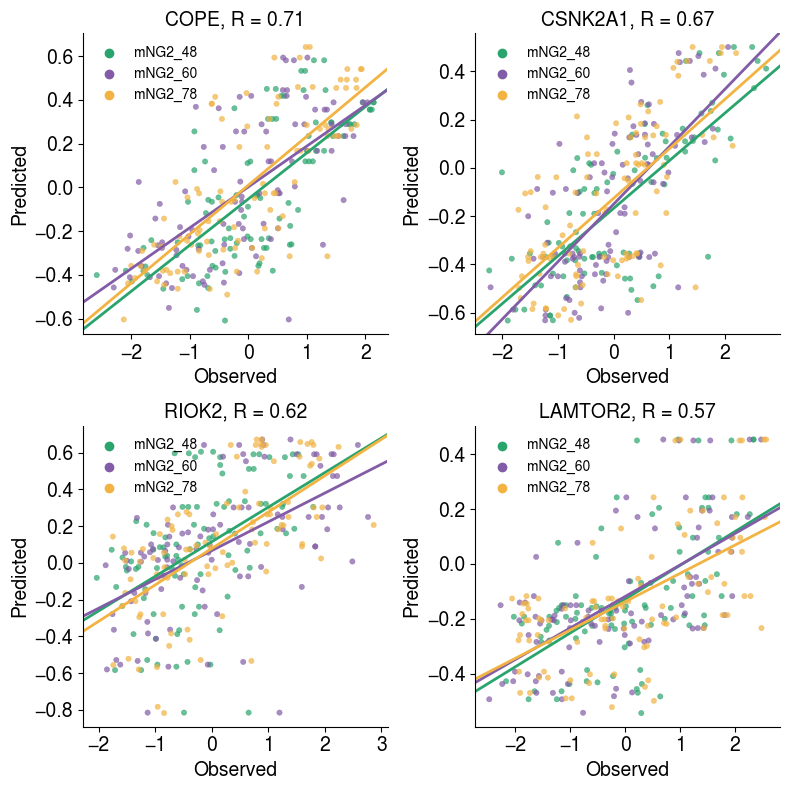

In [80]:
# top 4 genes (split by sublibrary and showing legend)
four_example_genes_model_predictions_by_sublib_scatterplot(genes_target_filtered_df, top_4_genes, 'top_4_genes', legend_flag=1)

0 HDAC1
mNG2_48
Spearman R:  0.5655114472188255  pvalue:  1.93399655421387e-09
Parameters:  const    -0.001897
y_test    0.195340
dtype: float64
R2:  0.3144229200708486
mNG2_60
Spearman R:  0.5469416586973751  pvalue:  8.14270057647101e-09
Parameters:  const    -0.015294
y_test    0.161779
dtype: float64
R2:  0.2917100693090027
mNG2_78
Spearman R:  0.5439478613882371  pvalue:  1.018352893060921e-08


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const     0.038283
y_test    0.168090
dtype: float64
R2:  0.3224828013917671
1 SMARCB1
mNG2_48
Spearman R:  0.5757568472868289  pvalue:  1.0347757354967781e-09
Parameters:  const     0.130137
y_test    0.223769
dtype: float64
R2:  0.29309560379980315
mNG2_60
Spearman R:  0.4887350493846569  pvalue:  5.034732035388952e-07
Parameters:  const     0.224966
y_test    0.239338
dtype: float64
R2:  0.21889957207320687
mNG2_78
Spearman R:  0.5601081177462831  pvalue:  3.5978848222012024e-09


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const     0.201775
y_test    0.297118
dtype: float64
R2:  0.28678208864210164
2 STT3B
mNG2_48
Spearman R:  0.33687339016269063  pvalue:  0.0007905123975168851
Parameters:  const     0.046523
y_test    0.149011
dtype: float64
R2:  0.14950286163915794
mNG2_60
Spearman R:  0.7132187917893045  pvalue:  3.554812572668498e-16
Parameters:  const     0.097061
y_test    0.240101
dtype: float64
R2:  0.5252624067946565
mNG2_78
Spearman R:  0.5427521022276239  pvalue:  1.1128285801109349e-08


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const     0.090784
y_test    0.185480
dtype: float64
R2:  0.29666634336377085
3 EMC4
mNG2_48
Spearman R:  0.6047896451519862  pvalue:  4.3675684709131753e-10
Parameters:  const     0.048656
y_test    0.156128
dtype: float64
R2:  0.3839709950469531
mNG2_60
Spearman R:  0.47468876503166674  pvalue:  1.9962329232003946e-06
Parameters:  const     0.070674
y_test    0.129108
dtype: float64
R2:  0.240107585355388
mNG2_78
Spearman R:  0.5047240072035447  pvalue:  3.923300574485808e-07


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const     0.082676
y_test    0.160609
dtype: float64
R2:  0.26089613052609395


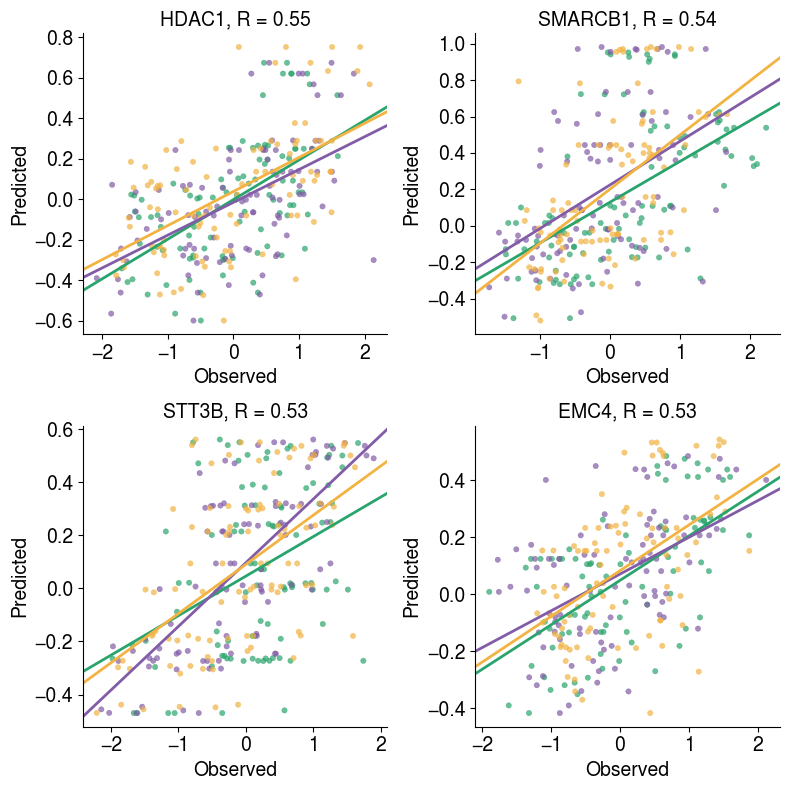

In [81]:
# top 5 to 8 genes (split by sublibrary)
four_example_genes_model_predictions_by_sublib_scatterplot(genes_target_filtered_df, top_5_8_genes, 'top_5_to_8_genes')

0 TUBG1
mNG2_48
Spearman R:  0.6131498850415017  pvalue:  4.4354672274906554e-10
Parameters:  const     0.083567
y_test    0.174472
dtype: float64
R2:  0.366668991314514
mNG2_60
Spearman R:  0.4773902102292  pvalue:  2.565088710648603e-06
Parameters:  const     0.171247
y_test    0.151541
dtype: float64
R2:  0.19635580211998405
mNG2_78
Spearman R:  0.5072890033412549  pvalue:  3.9073120929499177e-07


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const     0.098661
y_test    0.171465
dtype: float64
R2:  0.28230720558055855
1 VCP
mNG2_48
Spearman R:  0.25798623023915424  pvalue:  0.054897873768016164
Parameters:  const     0.046200
y_test    0.088906
dtype: float64
R2:  0.11905789057086436
mNG2_60
Spearman R:  0.5671509190489731  pvalue:  3.4524958768526922e-06
Parameters:  const     0.062804
y_test    0.156128
dtype: float64
R2:  0.3661376972596635
mNG2_78
Spearman R:  0.5983233759763187  pvalue:  1.7758090861339004e-07


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const     0.116235
y_test    0.179426
dtype: float64
R2:  0.3716354017174691
2 PMVK
mNG2_48
Spearman R:  0.3336342869988393  pvalue:  0.0020541837390256196
Parameters:  const     0.101987
y_test    0.099905
dtype: float64
R2:  0.11718316106462068
mNG2_60
Spearman R:  0.5666031762855923  pvalue:  2.877238634110724e-08
Parameters:  const     0.128667
y_test    0.114425
dtype: float64
R2:  0.28213084635882135
mNG2_78
Spearman R:  0.4771475327342834  pvalue:  2.5995992086856056e-06


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const     0.152852
y_test    0.107981
dtype: float64
R2:  0.22298306773531185
3 ACTB
mNG2_48
Spearman R:  0.5028982132420403  pvalue:  6.732288694556376e-06
Parameters:  const    -0.077700
y_test    0.149547
dtype: float64
R2:  0.25290407636858636
mNG2_60
Spearman R:  0.5069000794514967  pvalue:  6.4562281721150485e-06
Parameters:  const    -0.036904
y_test    0.173043
dtype: float64
R2:  0.27713982695307315
mNG2_78
Spearman R:  0.5395335475683944  pvalue:  4.122395627744435e-07


The palette list has more values (4) than needed (3), which may not be intended.


Parameters:  const     0.044343
y_test    0.171344
dtype: float64
R2:  0.3675605047069409


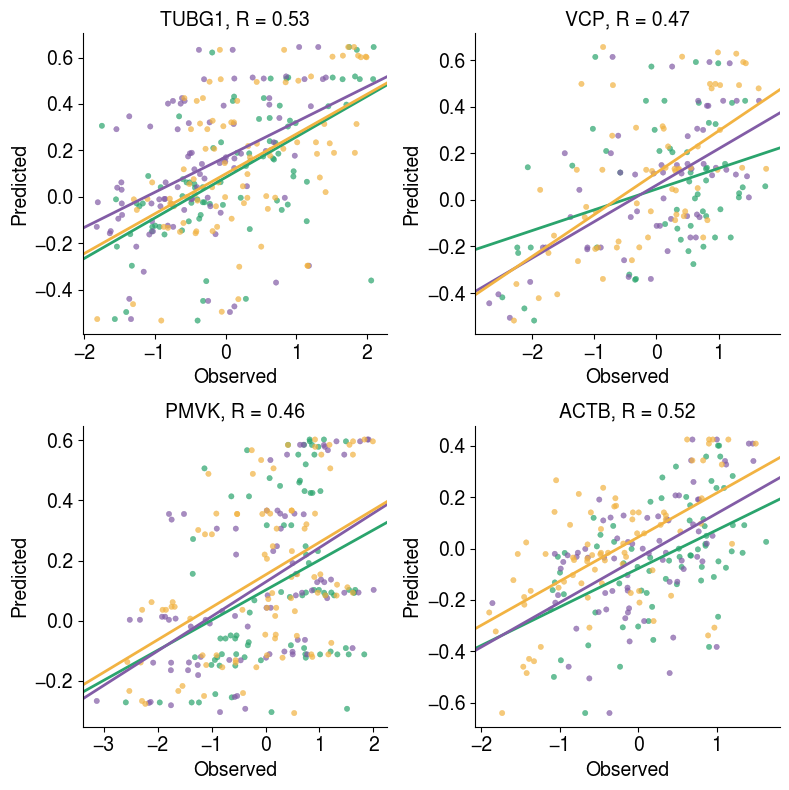

In [82]:
# top 9 to 12 genes (split by sublibrary)
four_example_genes_model_predictions_by_sublib_scatterplot(genes_target_filtered_df, top_9_12_genes, 'top_9_to_12_genes')

#################################################################################

precision plots

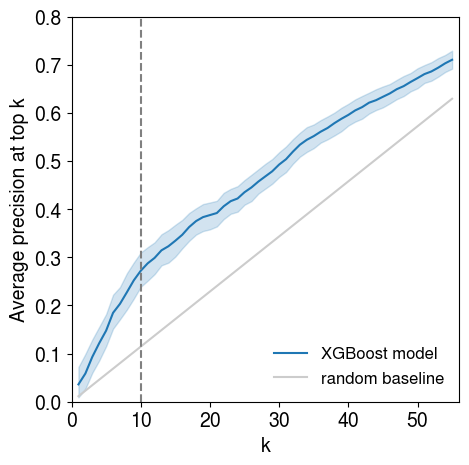

In [83]:
# average top k precision vs k (lineplot)
k = 10

# data variables
data = top_k_all_concat_df.copy()
x_var = 'top_k'
y_var = 'top_k_precision'
y_var_baseline = 'baseline_precision'

# parameters
fontsize = 14
x_label = 'k'
y_label = 'Average precision at top k'
#legend_labels = ['Model', 'Random']

# plot
plt.figure(figsize=(5,5))

g = sns.lineplot(data=data, x=x_var, y=y_var, errorbar=('ci',95), n_boot=1000, 
                 label='XGBoost model')
g = sns.lineplot(data=data, x=x_var, y=y_var_baseline, errorbar=None, 
                 linestyle='-', color='#CCCCCC', label='random baseline')

plt.axvline(k, linestyle='--', color='grey', alpha=1)

# spines
#g.spines[['right', 'top']].set_visible(False)

# x
plt.xlim([0,min_pegRNA_count+1])
plt.xticks(fontsize=fontsize)
plt.xlabel(x_label, fontsize=fontsize)

# y
plt.ylim([0,0.8])
plt.yticks(fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)

# legend
#handles, _ = plt.gca().get_legend_handles_labels()
#plt.legend(handles, legend_labels, markerfirst=False, handletextpad=0.1, fontsize=12, frameon=False)
plt.legend(fontsize=12, frameon=False, loc='lower right')

# title
#plt.title('')

########## save fig ##########
fig_name = 'fig5_' + save_date + '_' + model_info + '_average_top_k_precision_vs_k_sublib_genes_ci-95_nboot-1000_lineplot'
plt.savefig(fig_dir + fig_name + '.svg', dpi=1200, bbox_inches='tight')

# show plot
plt.show()


(37, 2)


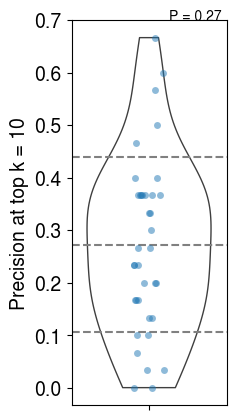

In [84]:
# sublib genes precision at top k = 10 (averaged by sublib)
# note, random jitter by stripplot may introduce different shifts of dots in horizontal direction between runs
# in future iteration use a fixed seed to keep display of dots consistent between runs

# data variables
data = eval_all_df.copy().groupby('Gene')['top_k_precision'].mean().reset_index()
print(data.shape)
x_var = None
y_var = 'top_k_precision'
#hue_var = 'opti_anti_spearman_corr'

# plot parameters
fig_size = (2,5)
fontsize = 14
x_label = None
y_label = 'Precision at top k = 10'
#legend_labels=['FDR < 0.1', 'FDR > 0.1']
#current_palette='RdBu'
#colors = [sns.color_palette(current_palette)[1], sns.color_palette(current_palette)[-2]]
#current_cmap = blue_pink_map
#current_cmap = 'cividis'

plt.figure(figsize=fig_size)

"""
g = sns.stripplot(data=data, y=y_var, hue=hue_var, 
                  palette=current_palette, alpha=0.5, dodge=True)
"""

g = sns.stripplot(data=data, y=y_var, alpha=0.5, dodge=True)


"""
# Generate a colormap
norm = plt.Normalize(data[hue_var].min(), data[hue_var].max())
sm = plt.cm.ScalarMappable(cmap=current_cmap, norm=norm)
sm.set_array([])

# Color the points based on another variable
colors = sm.to_rgba(data[hue_var])
for x_i, y_i, color in zip(g.collections[0].get_offsets()[:,0], g.collections[0].get_offsets()[:,1], colors):
    g.scatter(x_i, y_i, color=color, s=20)

# Create a colorbar
cbar = plt.colorbar(sm, ax=g)
cbar.set_label('Opti Anti Spearman correlation (R)')
"""

g = sns.violinplot(data=data, y=y_var, cut=0, inner=None, linewidth=1)
art = g.collections[-1]
art.set_facecolor('none')

"""
# calculate means
means = data.groupby(hue_var)[y_var].mean()

# add horizontal lines for means
for (hue, mean), color in zip(means.items(), colors):
    plt.axhline(y=mean, color=color, linestyle='--', alpha=1)
"""

mean = data[y_var].mean()
std = data[y_var].std()
plt.axhline(y=mean, color='grey', linestyle='--', alpha=1)
plt.axhline(y=mean-std, color='grey', linestyle='--', alpha=1)
plt.axhline(y=mean+std, color='grey', linestyle='--', alpha=1)

plt.text(0.13,0.7,'P = ' + str(round(mean,2)))

# x
plt.xticks(fontsize=fontsize)
plt.xlabel(x_label, fontsize=fontsize)

# y
#plt.ylim(top=1.06)
plt.yticks(fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)

# legend
"""
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], legend_labels, handletextpad=0.1, fontsize=12, frameon=False, 
           loc='center', bbox_to_anchor=(0.45, 1.08))
"""

########## save fig ##########
fig_name = 'fig5_' + save_date + '_' + model_info + '_precision_at_topk-10_sublib_genes_averaged_by_sublib_stripplot'
plt.savefig(fig_dir + fig_name + '.svg', dpi=1200, bbox_inches='tight')

# show plot
plt.show()

#################################################################################

build final model using most frequent best hyperparameter configuration

In [85]:
# Final model training and SHAP analysis code was generated with assistance of ChatGPT, developed by OpenAi.

In [86]:
X.shape, y.shape

((9873, 37), (9873,))

In [87]:
# Print best hyperparameter configurations and their frequencies
print("\nFrequency of best hyperparameter configurations:")
for params, count in best_params_frequency.items():
    print(f"{params}: {count}")

# Find the hyperparameter string representation with the highest frequency
most_frequent_params_str = max(best_params_frequency, key=best_params_frequency.get)

# Convert the string back into a dictionary
most_frequent_params = dict(eval(most_frequent_params_str))
num_boost_round = most_frequent_params.pop('n_estimators', 100)  # Using 100 as the default value if 'n_estimators' is not in the dictionary
print('most frequent best hyperparameter configuration:', most_frequent_params)
print('num_boost_round:', num_boost_round)

# Final model training
dtrain = xgb.DMatrix(X, label=y)
final_model = xgb.train(most_frequent_params, dtrain, num_boost_round=num_boost_round, 
                        evals=[(dtrain, 'train')], verbose_eval=False) #verbose_eval=25

# Save the model
model_name = 'xgboost_' + model_info
final_model.save_model(model_dir + model_name + '.model')

# Create an explainer object
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_final_df)


Frequency of best hyperparameter configurations:
[('alpha', 0.1), ('gamma', 0), ('lambda', 1), ('learning_rate', 0.05), ('max_depth', 3), ('n_estimators', 50)]: 8
[('alpha', 0.1), ('gamma', 0), ('lambda', 0.01), ('learning_rate', 0.05), ('max_depth', 3), ('n_estimators', 50)]: 6
[('alpha', 0), ('gamma', 0), ('lambda', 0.1), ('learning_rate', 0.05), ('max_depth', 3), ('n_estimators', 50)]: 2
[('alpha', 0.1), ('gamma', 0), ('lambda', 0.1), ('learning_rate', 0.05), ('max_depth', 3), ('n_estimators', 100)]: 1
[('alpha', 0.01), ('gamma', 0), ('lambda', 1), ('learning_rate', 0.05), ('max_depth', 3), ('n_estimators', 50)]: 4
[('alpha', 0.01), ('gamma', 0.1), ('lambda', 1), ('learning_rate', 0.05), ('max_depth', 3), ('n_estimators', 50)]: 3
[('alpha', 0.1), ('gamma', 0), ('lambda', 0.1), ('learning_rate', 0.05), ('max_depth', 3), ('n_estimators', 50)]: 2
[('alpha', 0), ('gamma', 0), ('lambda', 0.01), ('learning_rate', 0.05), ('max_depth', 3), ('n_estimators', 50)]: 2
[('alpha', 0.01), ('gamma

#################################################################################

final model shap analysis plots

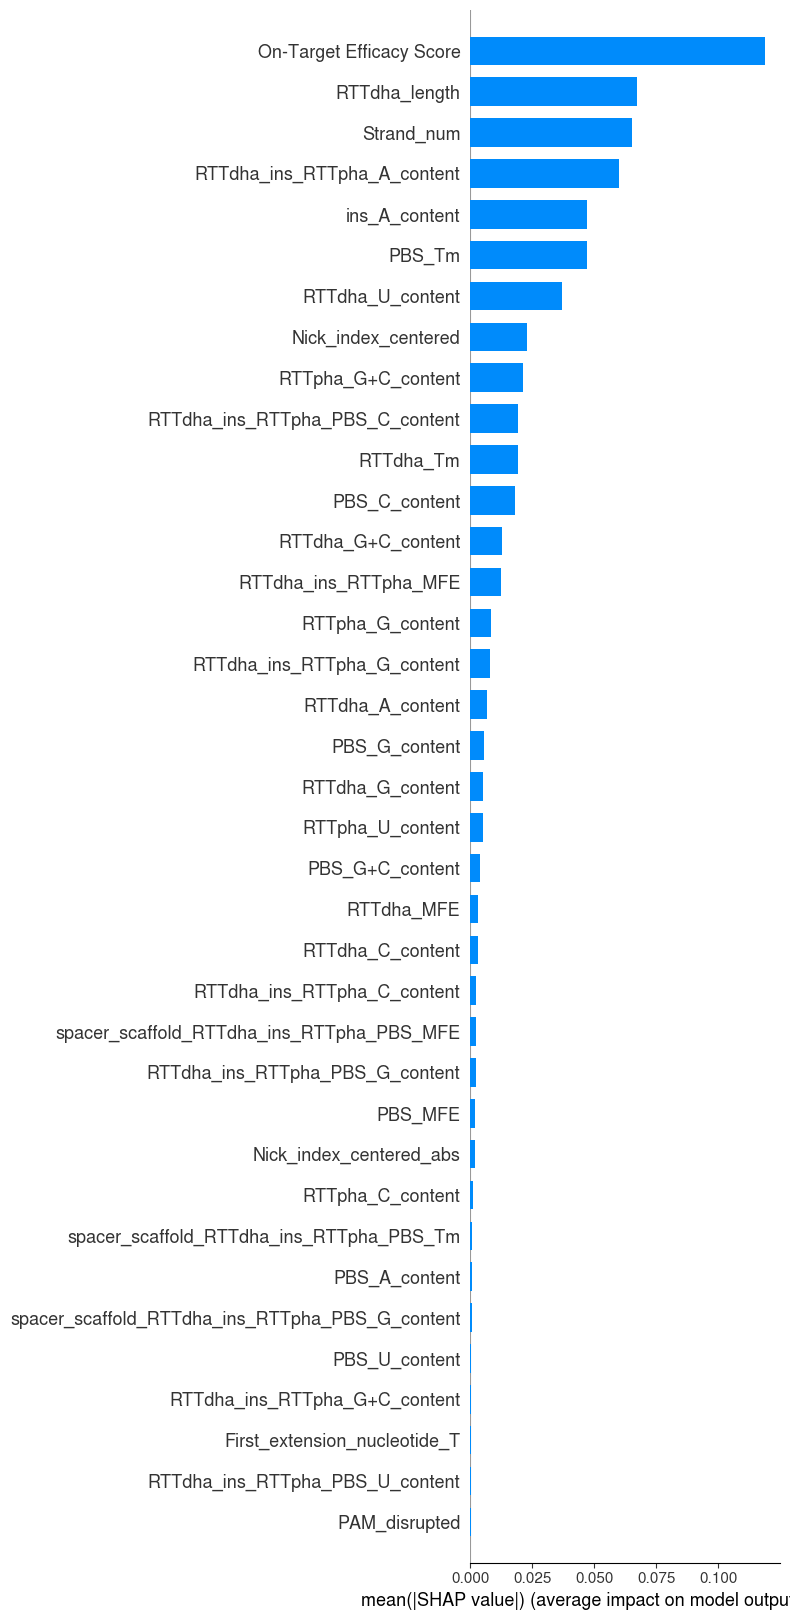

In [88]:
# Plot the summary of absolute SHAP values
shap.summary_plot(shap_values, X_final_df, max_display=100, plot_type='bar', show=True)

In [89]:
# Plot the summary of absolute SHAP values
shap.summary_plot(shap_values, X_final_df, max_display=100, plot_type='bar', show=False)

########## save fig ##########
fig_name = 'fig5_' + save_date + '_' + model_info + '_SHAP_summary_bar'
plt.savefig(fig_dir + fig_name + '.svg', dpi=1200, bbox_inches='tight')
plt.close()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


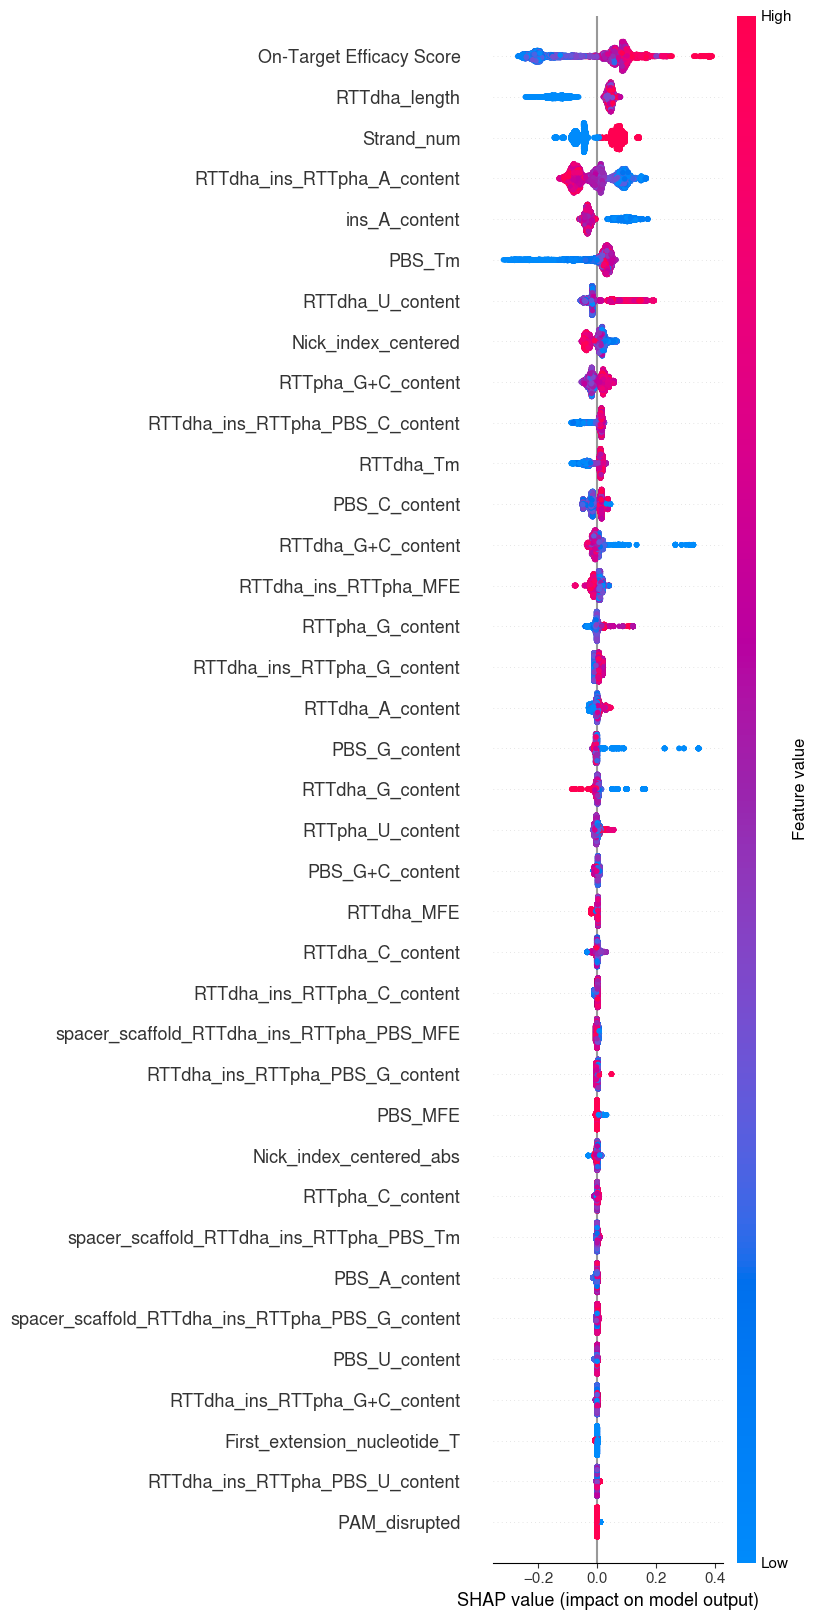

In [90]:
# Plot the summary of SHAP values (beeswarm plot)
shap.summary_plot(shap_values, X_final_df, max_display=100, plot_type='dot', show=True)

In [91]:
# Plot the summary of SHAP values (beeswarm plot)
shap.summary_plot(shap_values, X_final_df, max_display=100, plot_type='dot', show=False)

########## save fig ##########
fig_name = 'fig5_' + save_date + '_' + model_info + '_SHAP_summary_beeswarm'
plt.savefig(fig_dir + fig_name + '.svg', dpi=1200, bbox_inches='tight')
plt.close()

#################################################################################

get sorted features from SHAP analysis

In [92]:
# Compute mean SHAP values for each feature
mean_shap = np.mean(shap_values, axis=0)

# Compute mean absolute SHAP values for each feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Get the indices of the features sorted by importance
sorted_indices = np.argsort(mean_abs_shap)[::-1]

# Sort mean SHAP and mean absolute SHAP values
sorted_mean_shap = mean_shap[sorted_indices]
sorted_mean_abs_shap = mean_abs_shap[sorted_indices]

# Get the names of the top i features
sorted_features = X_final_df.columns[sorted_indices[:]].tolist()
print(sorted_features)

['On-Target Efficacy Score', 'RTTdha_length', 'Strand_num', 'RTTdha_ins_RTTpha_A_content', 'ins_A_content', 'PBS_Tm', 'RTTdha_U_content', 'Nick_index_centered', 'RTTpha_G+C_content', 'RTTdha_ins_RTTpha_PBS_C_content', 'RTTdha_Tm', 'PBS_C_content', 'RTTdha_G+C_content', 'RTTdha_ins_RTTpha_MFE', 'RTTpha_G_content', 'RTTdha_ins_RTTpha_G_content', 'RTTdha_A_content', 'PBS_G_content', 'RTTdha_G_content', 'RTTpha_U_content', 'PBS_G+C_content', 'RTTdha_MFE', 'RTTdha_C_content', 'RTTdha_ins_RTTpha_C_content', 'spacer_scaffold_RTTdha_ins_RTTpha_PBS_MFE', 'RTTdha_ins_RTTpha_PBS_G_content', 'PBS_MFE', 'Nick_index_centered_abs', 'RTTpha_C_content', 'spacer_scaffold_RTTdha_ins_RTTpha_PBS_Tm', 'PBS_A_content', 'spacer_scaffold_RTTdha_ins_RTTpha_PBS_G_content', 'PBS_U_content', 'RTTdha_ins_RTTpha_G+C_content', 'First_extension_nucleotide_T', 'RTTdha_ins_RTTpha_PBS_U_content', 'PAM_disrupted']


In [93]:
print(sorted_mean_shap)

[-2.6517881e-03 -9.5340674e-04  6.0544051e-03 -4.5573572e-03
 -5.9357210e-04  1.6186154e-03  5.7697872e-04 -1.8220631e-03
 -4.8337432e-04  6.8027014e-04 -6.1048086e-05  8.4431442e-05
  8.4619918e-05  7.5792690e-05  6.6207477e-04  1.8926333e-03
  4.9873471e-04 -4.6437420e-04  1.2175446e-04  2.0671058e-04
  1.3233171e-04 -8.1876628e-05 -3.9075522e-04 -1.9842367e-04
 -8.4377833e-05  5.1636941e-04 -2.7977419e-05 -1.0585196e-05
 -1.4133220e-04  4.1444850e-06 -3.9706376e-04  4.4604723e-05
 -1.2562591e-04 -1.5836969e-04 -4.2834281e-06 -3.8147984e-05
 -8.7702083e-06]


In [94]:
print(sorted_mean_abs_shap)

[0.11891481 0.06719121 0.06531083 0.06016438 0.04710696 0.04699796
 0.03710464 0.02297968 0.02139253 0.01946689 0.01927961 0.01801856
 0.01283014 0.01249619 0.0083849  0.00796954 0.00683953 0.00547574
 0.00538576 0.00524751 0.00393943 0.0032365  0.00306542 0.00246224
 0.00238883 0.00230935 0.0018905  0.00187371 0.00118152 0.00074567
 0.00073028 0.00065259 0.00050413 0.0004767  0.00042944 0.00034199
 0.00033375]
